# Supplementary Jupyter Notebook for Gleeson and Gibson (2021). Insights into the nature of plume-ridge interaction and outflux of H2O from the Galapagos Spreading Centre. Geochemistry, Geophysics, Geosystems

This Jupyter notebook provides the code that was used and developed during this study. Specifically, here we provide the key functions that were used to calculate the magma composition and ridge crustal thickness generated by melting of a two component mantle. The code shown here remains in development, but the latest version will always be made avilable through the lead authors GitHub page (). 

For the code below to run the following packages/libraries need to be installed or located in the file path. Most of these can be installed with Conda or pip. Exceptions include PyMelt (Matthews et al. 2020) and PerpleFun (this study), which can be downloaded from ... and ..., respectively.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import csv
import pickle
import random
import pymelt as m
import PerpleFun as p

In [2]:
plt.style.use('classic')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})

# Mantle melting calculations 1: Melt fraction vs depth

We use recent parameterisations (based on experimental and thermodynamic data) to simulate the melting behaviour of a lherzolite component (KLB-1) and a silica-undersaturated pyroxenite component (KG1). The PyMelt library (Matthews et al. 2020) allows you to investigate the influence of mantle potential temperature and the proportions of a lherzolite, harzburgite and pyroxenite source component. For more information on PyMelt please refer to...

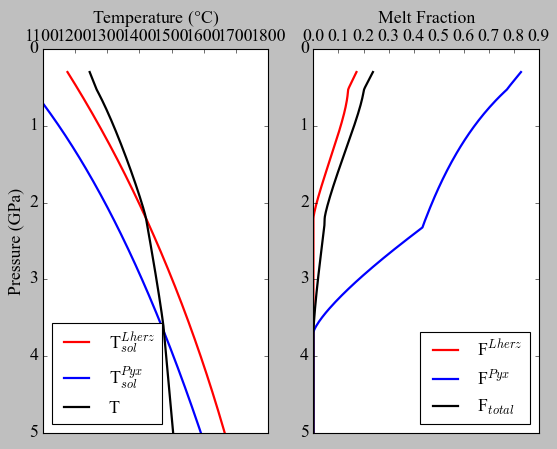

In [3]:
# define three lithological compositions
lz = m.LithologyKLB1()
px = m.LithologyKG1()
hz = m.LithologyNonMelting()

# define start, end, steps and Tp
Pstart=6 # GPa
Pend=0.3 # GPa
steps=201
Tp=1400 # Celcius

# define relative proportions - these do not need to add to one.
PropLz=0.9
PropPx=0.1
PropHz=0.0

# calculates solidi and liquidi
P=np.linspace(Pstart,Pend,steps)
lz_solidus = lz.TSolidus(P)
lz_liquidus = lz.TLiquidus(P)
px_solidus = px.TSolidus(P)
px_liquidus = px.TLiquidus(P)

# Define the mantle
mantle = m.mantle([lz,px,hz],[PropLz,PropPx,PropHz],['Lz', 'Px', 'Hz'])

# Carry out melting equations
column = mantle.AdiabaticMelt_1D(Tp,Pstart=Pstart,Pend=Pend,steps=steps)

# plot results
fig1, ((ax1a),(ax1b)) = plt.subplots(1, 2, figsize=(8,6))

ax1a.plot(lz_solidus,column.P,'-r',label="T$_{sol}^{Lherz}$",linewidth=2)
ax1a.plot(px_solidus,column.P,'-b',label="T$_{sol}^{Pyx}$",linewidth=2)
ax1a.plot(column.Temperature,column.P,'-k',label="T",linewidth=2)

ax1b.plot(column.F.Lz,column.P,'-r',label="F$^{Lherz}$",linewidth=2)
ax1b.plot(column.F.Px,column.P,'-b',label="F$^{Pyx}$",linewidth=2)
ax1b.plot(column.F_total,column.P,'-k',label="F$_{total}$",linewidth=2)

ax1a.set_ylim([5,0])
ax1a.set_xlim([1100,1800])
ax1a.xaxis.tick_top()
ax1a.set_xlabel('Temperature ($\degree$C)')
ax1a.xaxis.set_label_position('top')
ax1a.set_ylabel('Pressure (GPa)')
ax1a.legend(loc='lower left', fontsize=16)

ax1b.set_ylim([5,0])
ax1b.xaxis.tick_top()
ax1b.set_xlabel('Melt Fraction')
ax1b.xaxis.set_label_position('top')
ax1b.legend(loc='lower right', fontsize=16)



# Mantle melting calculations 2: Mineralogy of the source

One important factor for determining the trace element composition of melts produced by melting in a 2-component mantle is the mineralogy of the different source components (e.g. the proportion of garnet will influence the ratio of middle REE to heavy REE in the melt phase). One method is to use experimentally constrained 'melting equations' (e.g. descriptions of the change in mineral proportions with increasing melt fraction) as in Gleeson et al. (2020). However, this approach may not contain information about how mineral proportions change with pressure, a critical factor during adiabatic decompression melting.

Therefore, to estimate the modal mineralogy of the lherzolitic and pyroxenitic source components during mantle melting we use a thermodynamic approach. Specifically, we use Perple_X, along with the thermodynamic database of Holland and Powell (2018) and the solution models of Jennings and Holland (2015) to predict the mineralogy of the two source components as a function of pressure and melt fraction. 

We provide Perple_X calculation results for both the KG1 pyroxenite and KLB-1 lherzolite which can be loaded using pickle. Alternatively, new calculations can be performed in Perple_X and the PerpleFun library that was developed in this study can be used to extract all thermodynamic and compositional information from the werami output files for each phase. 

**Please note that option 1 must be selected unless the 'objs.pkl' file is already in the directory. This may take several minutes to run, but it will also save a 'objs.pkl' file so that if you had to re-run the code (i.e. restart the kernal) for any reason you can quickly load in these files using option 2.**

In [4]:
# either load in new Perple_X files (option 1) or load in the previously saved variables (option 2).
option=1
if option == 1:
    Names=['System','Melt','Olivine','Clinopyroxene','Orthopyroxene1','Orthopyroxene2','Plagioclase','Garnet','Spinel']

    KLB={}
    for Name in Names:
        KLB[Name]=p.loadPerpleData('KLB1_'+Name+'.tab')

    KLB=p.SplitSolid(KLB,['Orthopyroxene1','Orthopyroxene2'],'CaO,wt%',0.65)

    KLB=p.ConvertWt(KLB)

    KG1={}
    for Name in Names:
        KG1[Name]=p.loadPerpleData('KG1_'+Name+'.tab')

    KG1=p.SplitSolid(KG1,['Orthopyroxene1','Orthopyroxene2'],'CaO,wt%',0.65)

    KG1=p.ConvertWt(KG1)
    
    pickle.dump([KG1,KLB],open("objs.pkl","wb"))
    
elif option == 2:
    KG1,KLB=pickle.load(open("objs.pkl","rb"))

<ipython-input-5-6dbb4d939d46>:66: UserWarning: No contour levels were found within the data range.
  ax2f.contour(T,P, wt_KLB['Plagioclase'],levels=level,colors='black',linewidths=0.5)


Text(1200, 5550, 'Plagioclase')

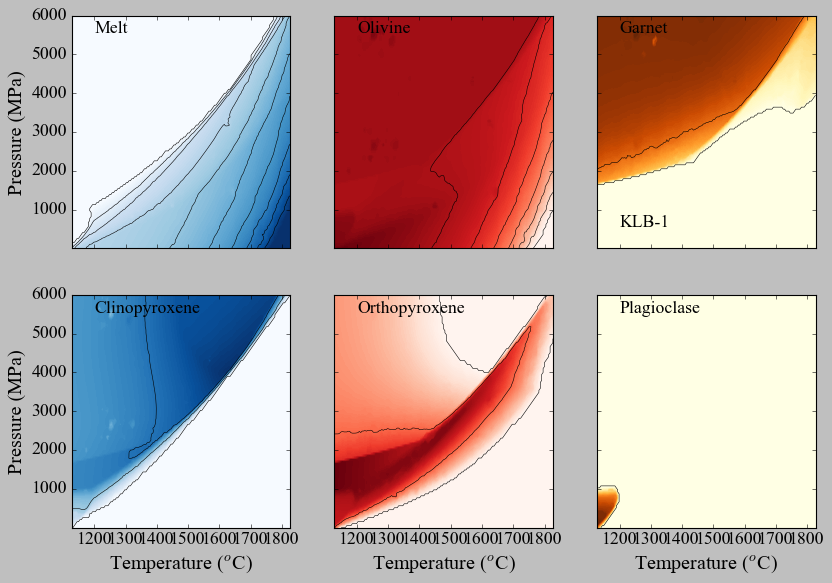

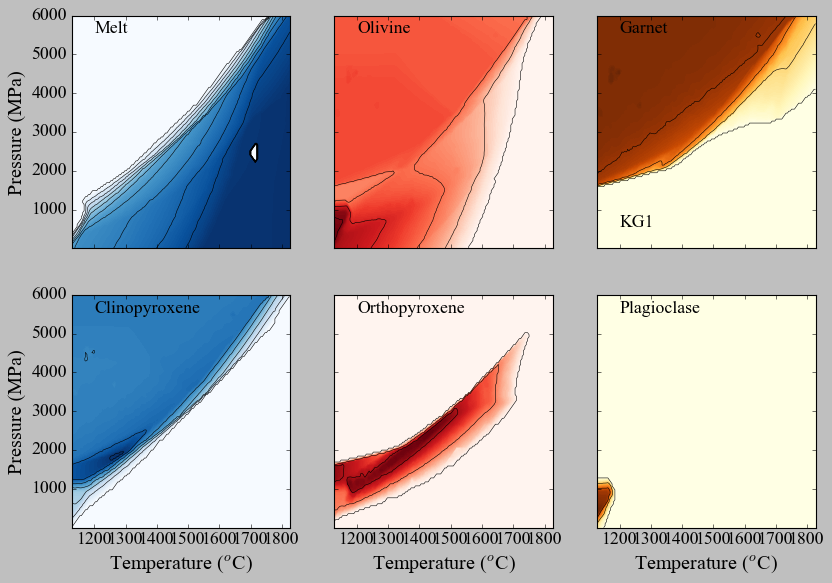

In [5]:
# plot information from Perple_X
level=[0,10,20,30,40,50,60,70,80,90,100]
Names=['System','Melt','Olivine','Clinopyroxene','Orthopyroxene1','Orthopyroxene2','Plagioclase','Garnet','Spinel']

wt_KLB={}
for Name in Names:
    Arr, T, P = p.PerpleMesh(KLB[Name],['wt,%'])
    wt_KLB[Name]=Arr

wt_KG1={}
for Name in Names:
    Arr, T, P = p.PerpleMesh(KG1[Name],['wt,%'])
    wt_KG1[Name]=Arr

# for the KLB-1 lherzolite
fig2, ((ax2a,ax2b,ax2c),(ax2d,ax2e,ax2f)) = plt.subplots(2, 3, figsize=(12,8))
ax2a.contourf(T,P, wt_KLB['Melt'],levels=101,alpha=1,cmap='Blues')
ax2a.contourf(T,P, wt_KLB['Melt'],levels=101,alpha=1,cmap='Blues')
ax2a.contourf(T,P, wt_KLB['Melt'],levels=101,alpha=1,cmap='Blues')
ax2a.contour(T,P, wt_KLB['Melt'],levels=level,colors='black',linewidths=0.5)
ax2a.set_xticklabels([])
ax2a.set_ylim([1,6000])
ax2a.set_ylabel('Pressure (MPa)',fontsize=18)
ax2a.text(1200, 5550, 'Melt')

ax2b.contourf(T,P, wt_KLB['Olivine'],levels=101,alpha=1,cmap='Reds')
ax2b.contourf(T,P, wt_KLB['Olivine'],levels=101,alpha=1,cmap='Reds')
ax2b.contourf(T,P, wt_KLB['Olivine'],levels=101,alpha=1,cmap='Reds')
ax2b.contour(T,P, wt_KLB['Olivine'],levels=level,colors='black',linewidths=0.5)
ax2b.set_xticklabels([])
ax2b.set_yticklabels([])
ax2b.set_ylim([1,6000])
ax2b.text(1200, 5550, 'Olivine')

ax2c.contourf(T,P, wt_KLB['Garnet'],levels=101,alpha=1,cmap='YlOrBr')
ax2c.contourf(T,P, wt_KLB['Garnet'],levels=101,alpha=1,cmap='YlOrBr')
ax2c.contourf(T,P, wt_KLB['Garnet'],levels=101,alpha=1,cmap='YlOrBr')
ax2c.contour(T,P, wt_KLB['Garnet'],levels=level,colors='black',linewidths=0.5)
ax2c.set_xticklabels([])
ax2c.set_yticklabels([])
ax2c.set_ylim([1,6000])
ax2c.text(1200, 5550, 'Garnet')
ax2c.text(1200, 550, 'KLB-1')

ax2d.contourf(T,P, wt_KLB['Clinopyroxene'],levels=101,alpha=1,cmap='Blues')
ax2d.contourf(T,P, wt_KLB['Clinopyroxene'],levels=101,alpha=1,cmap='Blues')
ax2d.contourf(T,P, wt_KLB['Clinopyroxene'],levels=101,alpha=1,cmap='Blues')
ax2d.contour(T,P, wt_KLB['Clinopyroxene'],levels=level,colors='black',linewidths=0.5)
ax2d.set_ylabel('Pressure (MPa)',fontsize=18)
ax2d.set_xlabel('Temperature ($^{o}$C)',fontsize=18)
ax2d.set_ylim([1,6000])
ax2d.text(1200, 5550, 'Clinopyroxene')

ax2e.contourf(T,P, wt_KLB['Orthopyroxene2'],levels=101,alpha=1,cmap='Reds')
ax2e.contourf(T,P, wt_KLB['Orthopyroxene2'],levels=101,alpha=1,cmap='Reds')
ax2e.contourf(T,P, wt_KLB['Orthopyroxene2'],levels=101,alpha=1,cmap='Reds')
ax2e.contour(T,P, wt_KLB['Orthopyroxene2'],levels=level,colors='black',linewidths=0.5)
ax2e.set_yticklabels([])
ax2e.set_xlabel('Temperature ($^{o}$C)',fontsize=18)
ax2e.set_ylim([1,6000])
ax2e.text(1200, 5550, 'Orthopyroxene')

ax2f.contourf(T,P, wt_KLB['Plagioclase'],levels=101,alpha=1,cmap='YlOrBr')
ax2f.contourf(T,P, wt_KLB['Plagioclase'],levels=101,alpha=1,cmap='YlOrBr')
ax2f.contourf(T,P, wt_KLB['Plagioclase'],levels=101,alpha=1,cmap='YlOrBr')
ax2f.contour(T,P, wt_KLB['Plagioclase'],levels=level,colors='black',linewidths=0.5)
ax2f.set_yticklabels([])
ax2f.set_xlabel('Temperature ($^{o}$C)',fontsize=18)
ax2f.set_ylim([1,6000])
ax2f.text(1200, 5550, 'Plagioclase')

# and for the KG1 pyroxenite
fig3, ((ax3a,ax3b,ax3c),(ax3d,ax3e,ax3f)) = plt.subplots(2, 3, figsize=(12,8))
ax3a.contourf(T,P, wt_KG1['Melt'],levels=101,alpha=1,cmap='Blues')
ax3a.contourf(T,P, wt_KG1['Melt'],levels=101,alpha=1,cmap='Blues')
ax3a.contourf(T,P, wt_KG1['Melt'],levels=101,alpha=1,cmap='Blues')
ax3a.contour(T,P, wt_KG1['Melt'],levels=level,colors='black',linewidths=0.5)
ax3a.set_xticklabels([])
ax3a.set_ylabel('Pressure (MPa)',fontsize=18)
ax3a.text(1200, 5550, 'Melt')
ax3a.set_ylim([1,6000])

ax3b.contourf(T,P, wt_KG1['Olivine'],levels=101,alpha=1,cmap='Reds')
ax3b.contourf(T,P, wt_KG1['Olivine'],levels=101,alpha=1,cmap='Reds')
ax3b.contourf(T,P, wt_KG1['Olivine'],levels=101,alpha=1,cmap='Reds')
ax3b.contour(T,P, wt_KG1['Olivine'],levels=level,colors='black',linewidths=0.5)
ax3b.set_xticklabels([])
ax3b.set_yticklabels([])
ax3b.set_ylim([1,6000])
ax3b.text(1200, 5550, 'Olivine')

ax3c.contourf(T,P, wt_KG1['Garnet'],levels=101,alpha=1,cmap='YlOrBr')
ax3c.contourf(T,P, wt_KG1['Garnet'],levels=101,alpha=1,cmap='YlOrBr')
ax3c.contourf(T,P, wt_KG1['Garnet'],levels=101,alpha=1,cmap='YlOrBr')
ax3c.contour(T,P, wt_KG1['Garnet'],levels=level,colors='black',linewidths=0.5)
ax3c.set_xticklabels([])
ax3c.set_yticklabels([])
ax3c.set_ylim([1,6000])
ax3c.text(1200, 5550, 'Garnet')
ax3c.text(1200, 550, 'KG1')

ax3d.contourf(T,P, wt_KG1['Clinopyroxene'],levels=101,alpha=1,cmap='Blues')
ax3d.contourf(T,P, wt_KG1['Clinopyroxene'],levels=101,alpha=1,cmap='Blues')
ax3d.contourf(T,P, wt_KG1['Clinopyroxene'],levels=101,alpha=1,cmap='Blues')
ax3d.contour(T,P, wt_KG1['Clinopyroxene'],levels=level,colors='black',linewidths=0.5)
ax3d.set_ylabel('Pressure (MPa)',fontsize=18)
ax3d.set_xlabel('Temperature ($^{o}$C)',fontsize=18)
ax3d.set_ylim([1,6000])
ax3d.text(1200, 5550, 'Clinopyroxene')

ax3e.contourf(T,P, wt_KG1['Orthopyroxene2'],levels=101,alpha=1,cmap='Reds')
ax3e.contourf(T,P, wt_KG1['Orthopyroxene2'],levels=101,alpha=1,cmap='Reds')
ax3e.contourf(T,P, wt_KG1['Orthopyroxene2'],levels=101,alpha=1,cmap='Reds')
ax3e.contour(T,P, wt_KG1['Orthopyroxene2'],levels=level,colors='black',linewidths=0.5)
ax3e.set_yticklabels([])
ax3e.set_xlabel('Temperature ($^{o}$C)',fontsize=18)
ax3e.set_ylim([1,6000])
ax3e.text(1200, 5550, 'Orthopyroxene')

ax3f.contourf(T,P, wt_KG1['Plagioclase'],levels=101,alpha=1,cmap='YlOrBr')
ax3f.contourf(T,P, wt_KG1['Plagioclase'],levels=101,alpha=1,cmap='YlOrBr')
ax3f.contourf(T,P, wt_KG1['Plagioclase'],levels=101,alpha=1,cmap='YlOrBr')
ax3f.contour(T,P, wt_KG1['Plagioclase'],levels=level,colors='black',linewidths=0.5)
ax3f.set_yticklabels([])
ax3f.set_xlabel('Temperature ($^{o}$C)',fontsize=18)
ax3f.set_ylim([1,6000])
ax3f.text(1200, 5550, 'Plagioclase')

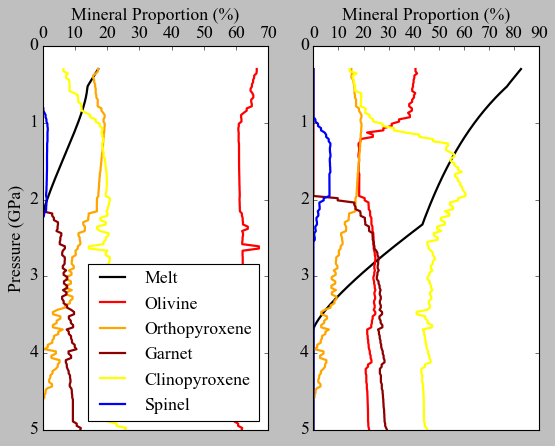

In [6]:
# plot Perple_X information along the P-T path defined by PyMelt (ensure the 2nd cell has been run prior to this)
# work out mineral assemblages along FM path
Per=pd.DataFrame()
Pyx=pd.DataFrame()
Min=['Olivine','Clinopyroxene','Orthopyroxene1','Orthopyroxene2','Spinel','Garnet']
for min in Min:
    arr=np.zeros(len(column.P))
    arr2=np.zeros(len(column.P))
    for i in range(0,len(arr)):
        P=KLB['System']['P(bar)'][(np.abs(KLB['System']['P(bar)']/10000-column.P[i]).argmin())]
        F=((KLB['Melt']['wt,%'][KLB['System']['P(bar)']==P]/KLB['System']['wt,%'][KLB['System']['P(bar)']==P]-column.F.Lz[i]).argmin())
        F2=((KG1['Melt']['wt,%'][KG1['System']['P(bar)']==P]/KG1['System']['wt,%'][KG1['System']['P(bar)']==P]-column.F.Px[i]).argmin())
        A=KLB[min]['wt,%'][KLB['System']['P(bar)']==P]
        B=KG1[min]['wt,%'][KG1['System']['P(bar)']==P]
        arr[i]=A.iloc[F] #KLB[min]['wt,%'][F]
        arr2[i]=B.iloc[F2] #KG1[min]['wt,%'][F2]

    Per[min]=arr
    Pyx[min]=arr2

Per=Per.fillna(0)
Pyx=Pyx.fillna(0)

# plot results
fig4, ((ax4a),(ax4b)) = plt.subplots(1, 2, figsize=(8,6))

ax4a.plot(column.F.Lz*100,column.P,'-k',label="Melt",linewidth=2)
ax4a.plot(Per['Olivine'],column.P,'-r',label="Olivine",linewidth=2)
ax4a.plot(Per['Orthopyroxene1']+Per['Orthopyroxene2'],column.P,'-',label="Orthopyroxene",linewidth=2,color='orange')
ax4a.plot(Per['Garnet'],column.P,'-',label="Garnet",linewidth=2,color="darkred")
ax4a.plot(Per['Clinopyroxene'],column.P,'-',label="Clinopyroxene",linewidth=2,color="yellow")
ax4a.plot(Per['Spinel'],column.P,'-',label="Spinel",linewidth=2,color="blue")

ax4b.plot(column.F.Px*100,column.P,'-k',label="Melt",linewidth=2)
ax4b.plot(Pyx['Olivine'],column.P,'-r',label="Olivine",linewidth=2)
ax4b.plot(Pyx['Orthopyroxene1']+Per['Orthopyroxene2'],column.P,'-',label="Orthopyroxene",linewidth=2,color='orange')
ax4b.plot(Pyx['Garnet'],column.P,'-',label="Garnet",linewidth=2,color="darkred")
ax4b.plot(Pyx['Clinopyroxene'],column.P,'-',label="Clinopyroxene",linewidth=2,color="yellow")
ax4b.plot(Pyx['Spinel'],column.P,'-',label="Spinel",linewidth=2,color="blue")

ax4a.set_ylim([5,0])
#ax4a.set_xlim([1100,1800])
ax4a.xaxis.tick_top()
ax4a.set_xlabel('Mineral Proportion (%)')
ax4a.xaxis.set_label_position('top')
ax4a.set_ylabel('Pressure (GPa)')
ax4a.legend(loc='lower right', fontsize=16)

ax4b.set_ylim([5,0])
ax4b.xaxis.tick_top()
ax4b.set_xlabel('Mineral Proportion (%)')
ax4b.xaxis.set_label_position('top')
#ax4b.legend(loc='lower right', fontsize=16)

# Mantle melting 3: Calculating trace element compositions

The trace element composition of the aggregate melt produced by mantle melting beneath a ridge axis is calculated via the following method:

First, we calculate the instantaneous fractional melts that are formed within a column of adiabatically decompressing mantle. This is achieved using a non-modal batch melting equation:

$$C_{l}/C_{o} = 1/(D+F*(1-P))$$

where $C_{l}$ represents the concentration of some trace element in the melt ; $C_{o}$ represents the concentration in the initial solid assemblage; $F$ is the instananeous melt fraction formed; $D$ is the partition coefficient weigthed by the proportion of each mineral in the solid assemblage; and $P$ represents the partion coefficient of each mineral weighted by the contribution of that mineral to the melt (not it's original proportion).

This calculation is performed at discreet pressure intervals, with the residue formed during the previous model step forming the initial solid assemblage during the next melting calculation. The pressure interval chosen for the calculations is controlled by the user by chnaged the number of 'steps' specified in the PyMelt models.

Second, we calculate the accumulated melts that form from each parcel of mantle residue that is exciting the melting region. In other words, for each depth interval within the melting region, we calculate the aggregated melt composition for melting to that pressure:

$$ C_{column}^{P_i} = \sum^{i}_{j=0} C^{P_j}*Frac^j $$ 

where $C^{P_j}$ represents the composition of the melt produced at location $j$ (or pressure $P_j$) in the melt column, and $Frac^j$ represents the fraction of melt produced at pressure $P_j$ relative to the total melt fraction of that source component at pressure $P_i$.

We then calculate the composition of the aggregated pooled melt at the ridge axis by summing the composition of aggregated melts formed at each pressure interval in the melt column weigted by their contribution to the final pooled melt phase. This weighting factor is determining by multiplying the total melt fraction of the source component at each depth interval with the relative lateral flow velocity of material exiting the melting region ($U_r$), i.e., $ \omega^{P_i} = (U_r^{P_i}*F^{P_i})/(\sum_{j=0}^{n} U_r^{P_j}*F^{P_j}) $ 

$$ C_{lith_1} = \sum_{i=0}^{n} \omega^{P_i}*C_{column}^{P_i} $$

This calculation is performed for all lithologies and the final aggregated melt can then be calculated via:

$$ C_{final} = P_d*C_{Lhz}+(1-Pd)*C_{Pyx} $$

where $P_d$ represents the proportion of material derived from the depleted/lherzolitic component and is calculated via:

$$ P_d= \sum_{i=0}^{n} \omega^{P_i}*(F_{Lhz}^{P_i}*X_d)/(F_{Lhz}^{P_i}*Xd+F_{Pyx}^{P_i}*(1-X_d)) $$

where $X_d$ represents the mass

In a similar manner, the crustal thickness produced by melting beneath the ridge axis can be calculated by summing the volume of melt produced at each depth in the melting region per unit time (i.e accounting for changes in the relative flow velocity of material leaving the melting zone:

$$ Crustal\ Thickness = \sum^{n}_{i=0} (\rho_{solid}^{P_i}/\rho_{liquid})*F_{total}^{P_i}*U_r^{P_i}*\delta h $$

where $\delta h$ represents the height (in m) between each calculation step in the melting region and $\rho_{solid}^{P_i}$ represents the mean density of the solid components weighted by their contribution to the melt phase. Here we assume that $\rho_{Pyx} = 3400\ kg.m^{-3}$, $\rho_{Lhz} = 3300\ kg.m^{-3}$ and $\rho_{melt} = 2900\ kg.m^{-3}$.

In addition, the composition of channelised melt formed in the Galapagos plume step is calculated using equation (2) above, but with the calculation terminating at the pressure of channel formation.

In [7]:
# define function to calculate the composition of a channelised melt formed in a plume stem
def Channel(column, Esource=None, KG1=None, Pchannel=None):
    if Esource is None:
        Cpin={'Pb': 0.052, 'Sr': 43.546, 'La': 0.907, 'Ce': 3.1555, 'Pr': 0.7435, 'Nd': 3.9665, 'Sm': 1.45, 'Eu': 0.563, 'Gd': 2.177, 'Tb': 0.342, 'Dy': 2.7405, 'Ho': 0.479, 'Er': 1.7295, 'Yb':1.669, 'Lu': 0.253, 'H2O': 320, 'F':60}
    else:
        if Esource==1:
            Cpin={'Pb': 0.3355, 'Sr': 66.05, 'La': 2.7285, 'Ce': 6.9375, 'Pr': 1.078, 'Nd': 5.267, 'Sm': 1.667, 'Eu': 0.614, 'Gd': 2.148, 'Tb': 0.364, 'Dy': 2.5935, 'Ho': 0.507, 'Er': 1.59, 'Yb':1.5265, 'Lu': 0.23, 'H2O': 950, 'F':115}

        if Esource==2:
            Cpin={'Pb': 0.052, 'Sr': 43.546, 'La': 0.907, 'Ce': 3.1555, 'Pr': 0.7435, 'Nd': 3.9665, 'Sm': 1.45, 'Eu': 0.563, 'Gd': 2.177, 'Tb': 0.342, 'Dy': 2.7405, 'Ho': 0.479, 'Er': 1.7295, 'Yb':1.669, 'Lu': 0.253, 'H2O': 350, 'F':60}

    if KG1 is None:
        KG1,KLB=pickle.load(open("objs.pkl","rb"))
    
    if Pchannel is None:
        Pchannel=column.P[next(x for x, val in enumerate(column.F.Lz) if val>0)]
        BBB=next(x for x, val in enumerate(column.F.Lz) if val>0)
    else:
        BBB=(np.abs(Pchannel-column.P).argmin())
    
    AAA=next(x for x, val in enumerate(column.F.Px) if val>0)
    
    # define partition coeffs
    Element=['Pb','Sr','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb','Lu','H2O','F']
    Dol={'Pb': 0.003, 'Sr': 0.00004, 'La': 0.0005, 'Ce': 0.0005, 'Pr': 0.0008, 'Nd': 0.00042, 'Sm': 0.0011,'Eu': 0.0016, 'Gd': 0.0011, 'Tb': 0.0015, 'Dy': 0.0027, 'Ho': 0.0016, 'Er': 0.013, 'Yb': 0.02, 'Lu': 0.02, 'H2O': 0.00125, 'F':0.005}
    DOp={'Pb': 0.009, 'Sr': 0.0007, 'La': 0.0031, 'Ce': 0.004, 'Pr': 0.0048, 'Nd': 0.012, 'Sm': 0.02, 'Eu': 0.013, 'Gd': 0.0065, 'Tb': 0.019, 'Dy': 0.0011, 'Ho': 0.0026, 'Er': 0.045, 'Yb': 0.08, 'Lu': 0.12, 'H2O': 0.0145, 'F':0.05}
    DCp={'Pb': 0.012, 'Sr': 0.091, 'La': 0.049, 'Ce': 0.08, 'Pr': 0.126, 'Nd': 0.178, 'Sm': 0.293, 'Eu': 0.335, 'Gd': 0.35, 'Tb': 0.403, 'Dy': 0.4, 'Ho': 0.427, 'Er': 0.42, 'Yb': 0.4,'Lu': 0.376, 'H2O': 0.0139, 'F':0.13}
    DG={'Pb': 0.005, 'Sr': 0.0007, 'La': 0.001, 'Ce': 0.005, 'Pr': 0.014, 'Nd': 0.052, 'Sm': 0.25, 'Eu': 0.496, 'Gd': 0.848, 'Tb': 1.477, 'Dy': 2.2, 'Ho': 3.315, 'Er': 4.4, 'Yb': 6.6, 'Lu': 7.1, 'H2O': 0.00315, 'F':0.0123}
    DS={'Pb': 0.00, 'Sr': 0.0000, 'La': 0.0006, 'Ce': 0.0006, 'Pr': 0.0006, 'Nd': 0.0006, 'Sm': 0.0006, 'Eu': 0.0006, 'Gd': 0.0006, 'Tb': 0.0006, 'Dy': 0.0015, 'Ho': 0.0023, 'Er': 0.003, 'Yb': 0.0045, 'Lu': 0.0052, 'H2O': 0.0006, 'F':0.0006}
    
    U=np.zeros(len(column.P))
    for i in range(0,len(U)):
        if i<AAA:
            U[i]=0
        elif i>AAA:
            U[i]=(2*((column.P.values[i]-column.P.values[-1])/(column.P.values[AAA]-column.P.values[-1]))-((column.P.values[i]-column.P.values[-1])/(column.P.values[AAA]-column.P.values[-1]))**2)
         
    Fe=np.zeros(len(column.P))
    Femass=np.zeros(len(column.P))

    CE=np.zeros([len(column.P),len(Dol.values())])
    
    for i in range(0,len(column.P)):
        if i==0:
            Fe[i]=column.F.Px[i]
            Femass[i]=column.F.Px[i]
        else:
            Fe[i]=(column.F.Px[i]-column.F.Px[i-1])/(1-column.F.Px[i-1]) # melt fraction at each step (of the material that is remaining)
            Femass[i]=column.F.Px[i]-column.F.Px[i-1] # melt fraction at each step relative to the initial mass in the system
            
    Frac=Femass[0:BBB]*U[0:BBB]/np.sum(Femass[0:BBB]*U[0:BBB])
    
    # work out mineral assemblages along FM path
    Pyx=pd.DataFrame()
    Min=['Olivine','Clinopyroxene','Orthopyroxene1','Orthopyroxene2','Spinel','Garnet']
    for min in Min:
        arr=np.zeros(len(column.P))
        arr2=np.zeros(len(column.P))
        for i in range(0,len(arr)):
            P=KG1['System']['P(bar)'][(np.abs(KG1['System']['P(bar)']/10000-column.P[i]).argmin())]
            F2=((KG1['Melt']['wt,%'][KG1['System']['P(bar)']==P]/KG1['System']['wt,%'][KG1['System']['P(bar)']==P]-column.F.Px[i]).argmin())
            B=KG1[min]['wt,%'][KG1['System']['P(bar)']==P]
            arr2[i]=B.iloc[F2] #KG1[min]['wt,%'][F2]

        Pyx[min]=arr2

    Pyx=Pyx.fillna(0)

    DE=pd.DataFrame(data=np.zeros((len(column.P),len(Element))),columns=Element)
    PE=pd.DataFrame(data=np.zeros((len(column.P),len(Element))),columns=Element)
    SystemP=Pyx['Olivine']+Pyx['Clinopyroxene']+Pyx['Orthopyroxene1']+Pyx['Orthopyroxene2']+Pyx['Spinel']+Pyx['Garnet']
    for El in Element:
        DE[El]=Dol[El]*Pyx['Olivine']/SystemP+DOp[El]*(Pyx['Orthopyroxene1']+Pyx['Orthopyroxene2'])/SystemP+DCp[El]*Pyx['Clinopyroxene']/SystemP+DS[El]*Pyx['Spinel']/SystemP+DG[El]*Pyx['Garnet']/SystemP

        for i in range(0,len(column.P)):
            if i>0:
                totp=0
                for min in Min:
                    totp=totp+Pyx[min].loc[i]-Pyx[min].loc[i-1]

                if totp==0:
                    PE[El]=DE[El]
                else:
                    PE[El].loc[i]=Dol[El]*(Pyx['Olivine'].loc[i]-Pyx['Olivine'].loc[i-1])/totp+DCp[El]*(Pyx['Clinopyroxene'].loc[i]-Pyx['Clinopyroxene'].loc[i-1])/totp+DOp[El]*((Pyx['Orthopyroxene1'].loc[i]-Pyx['Orthopyroxene1'].loc[i-1])+(Pyx['Orthopyroxene2'].loc[i]-Pyx['Orthopyroxene2'].loc[i-1]))/totp+DS[El]*(Pyx['Spinel'].loc[i]-Pyx['Spinel'].loc[i-1])/totp+DG[El]*(Pyx['Garnet'].loc[i]-Pyx['Garnet'].loc[i-1])/totp
    
    for i in range(0,len(column.P)):
        if column.F.Px[i]>0:
            if i==AAA:
                CE[i,:]=np.fromiter(Cpin.values(), dtype=float)/(DE.loc[i].values+Fe[i]*(1-PE.loc[i].values))
                ResE=np.fromiter(Cpin.values(), dtype=float)*((DE.loc[i].values-Fe[i]*PE.loc[i].values)/(1-Fe[i]))*(1/(DE.loc[i].values+Fe[i]*(1-PE.loc[i].values)))
            elif i>AAA:
                CE[i,:]=ResE/(DE.loc[i].values+Fe[i]*(1-PE.loc[i].values))
                ResE=ResE*((DE.loc[i].values-Fe[i]*PE.loc[i].values)/(1-Fe[i]))*(1/(DE.loc[i].values+Fe[i]*(1-PE.loc[i].values)))

    Frac=Frac.reshape(len(Frac),1)
    C_channel=np.sum(CE[0:BBB,:]*Frac,axis=0)
    
    return C_channel
        
# define the function to calculated the trace element composition of the pooled fractional melts
def TraceCalc(column,Dsource=None,Esource=None,Ur=None,Uchange=None,Xd=None,Ffactor=None, KLB=None, KG1=None):
    if Dsource is None:
        Dsource=1
        
    if Xd is None:
        Xd=0
    
    if Esource is None:
        Esource=1
    
    if Ur is None:
        Ur=1
    
    if Ffactor is None:
        Ffactor=1
    
    if KLB is None:
        KG1,KLB=pickle.load(open("objs.pkl","rb"))
    
    rho=3300
    g=9.81
    Pressure=column.P
    dh=((Pressure[0]-Pressure[1])*10**9)/(rho*g)

    AAA=next(x for x, val in enumerate(column.F.Px) if val>0)
    BBB=next(x for x, val in enumerate(column.F.Lz) if val>0)
    
    if Uchange is None:
        Uchange=column.P[BBB]

    final=np.array([Pressure,column.F.Px,column.F.Lz]).T

    # define partition coeffs
    Element=['Pb','Sr','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb','Lu','H2O','F']
    Dol={'Pb': 0.003, 'Sr': 0.00004, 'La': 0.0005, 'Ce': 0.0005, 'Pr': 0.0008, 'Nd': 0.00042, 'Sm': 0.0011,'Eu': 0.0016, 'Gd': 0.0011, 'Tb': 0.0015, 'Dy': 0.0027, 'Ho': 0.0016, 'Er': 0.013, 'Yb': 0.02, 'Lu': 0.02, 'H2O': 0.0015, 'F':0.005}
    DOp={'Pb': 0.009, 'Sr': 0.0007, 'La': 0.0031, 'Ce': 0.004, 'Pr': 0.0048, 'Nd': 0.012, 'Sm': 0.02, 'Eu': 0.013, 'Gd': 0.0065, 'Tb': 0.019, 'Dy': 0.0011, 'Ho': 0.0026, 'Er': 0.045, 'Yb': 0.08, 'Lu': 0.12, 'H2O': 0.0145, 'F':0.05}
    DCp={'Pb': 0.012, 'Sr': 0.091, 'La': 0.049, 'Ce': 0.08, 'Pr': 0.126, 'Nd': 0.178, 'Sm': 0.293, 'Eu': 0.335, 'Gd': 0.35, 'Tb': 0.403, 'Dy': 0.4, 'Ho': 0.427, 'Er': 0.42, 'Yb': 0.4,'Lu': 0.376, 'H2O': 0.0139, 'F':0.13}
    DG={'Pb': 0.005, 'Sr': 0.0007, 'La': 0.001, 'Ce': 0.005, 'Pr': 0.014, 'Nd': 0.052, 'Sm': 0.25, 'Eu': 0.496, 'Gd': 0.848, 'Tb': 1.477, 'Dy': 2.2, 'Ho': 3.315, 'Er': 4.4, 'Yb': 6.6, 'Lu': 7.1, 'H2O': 0.00315, 'F':0.0123}
    DS={'Pb': 0.00, 'Sr': 0.0000, 'La': 0.0006, 'Ce': 0.0006, 'Pr': 0.0006, 'Nd': 0.0006, 'Sm': 0.0006, 'Eu': 0.0006, 'Gd': 0.0006, 'Tb': 0.0006, 'Dy': 0.0015, 'Ho': 0.0023, 'Er': 0.003, 'Yb': 0.0045, 'Lu': 0.0052, 'H2O': 0.0006, 'F':0.0006}

    if Dsource ==1:
        Cdin={'Pb': 0.018, 'Sr': 7.664, 'La': 0.192, 'Ce': 0.550, 'Pr': 0.107, 'Nd': 0.581, 'Sm': 0.239, 'Eu': 0.096, 'Gd': 0.358, 'Tb': 0.07, 'Dy': 0.505, 'Ho': 0.115, 'Er': 0.348, 'Yb': 0.365, 'Lu': 0.058, 'H2O': 144, 'F':10.5}

    if Dsource ==2:
        Cdin={'Pb': 0.0237, 'Sr': 8.7486, 'La': 0.2465, 'Ce': 0.66, 'Pr': 0.1213, 'Nd': 0.6459, 'Sm': 0.2543, 'Eu': 0.1013, 'Gd': 0.3758, 'Tb': 0.0727, 'Dy': 0.5211, 'Ho': 0.1183, 'Er': 0.3569, 'Yb': 0.3726, 'Lu': 0.05, 'H2O': 184, 'F':19}
        
    if Dsource ==3:
        Cdin={'Pb': 0.014, 'Sr': 6.092, 'La': 0.134, 'Ce': 0.421, 'Pr': 0.087, 'Nd': 0.483, 'Sm': 0.21, 'Eu': 0.086, 'Gd': 0.324, 'Tb': 0.064, 'Dy': 0.471, 'Ho': 0.108, 'Er': 0.329, 'Yb': 0.348, 'Lu': 0.056, 'H2O': 100, 'F':12}

    if Esource==1:
        Cpin={'Pb': 0.3355, 'Sr': 66.05, 'La': 2.7285, 'Ce': 6.9375, 'Pr': 1.078, 'Nd': 5.267, 'Sm': 1.667, 'Eu': 0.614, 'Gd': 2.148, 'Tb': 0.364, 'Dy': 2.5935, 'Ho': 0.507, 'Er': 1.59, 'Yb':1.5265, 'Lu': 0.23, 'H2O': 950, 'F':115}

    if Esource==2:
        Cpin={'Pb': 0.052, 'Sr': 43.546, 'La': 0.907, 'Ce': 3.1555, 'Pr': 0.7435, 'Nd': 3.9665, 'Sm': 1.45, 'Eu': 0.563, 'Gd': 2.177, 'Tb': 0.342, 'Dy': 2.7405, 'Ho': 0.479, 'Er': 1.7295, 'Yb':1.669, 'Lu': 0.253, 'H2O': 350, 'F':60}

    # work out mineral assemblages along FM path
    Per=pd.DataFrame()
    Pyx=pd.DataFrame()
    Min=['Olivine','Clinopyroxene','Orthopyroxene1','Orthopyroxene2','Spinel','Garnet']
    for min in Min:
        arr=np.zeros(len(final[:,1]))
        arr2=np.zeros(len(final[:,1]))
        for i in range(0,len(arr)):
            P=KLB['System']['P(bar)'][(np.abs(KLB['System']['P(bar)']/10000-column.P[i]).argmin())]
            F=((KLB['Melt']['wt,%'][KLB['System']['P(bar)']==P]/KLB['System']['wt,%'][KLB['System']['P(bar)']==P]-column.F.Lz[i]).argmin())
            F2=((KG1['Melt']['wt,%'][KG1['System']['P(bar)']==P]/KG1['System']['wt,%'][KG1['System']['P(bar)']==P]-column.F.Px[i]).argmin())
            A=KLB[min]['wt,%'][KLB['System']['P(bar)']==P]
            B=KG1[min]['wt,%'][KG1['System']['P(bar)']==P]
            arr[i]=A.iloc[F] #KLB[min]['wt,%'][F]
            arr2[i]=B.iloc[F2] #KG1[min]['wt,%'][F2]

        Per[min]=arr
        Pyx[min]=arr2

    Per=Per.fillna(0)
    Pyx=Pyx.fillna(0)

    D=pd.DataFrame(data=np.zeros((len(column.P),len(Element))),columns=Element)
    DE=pd.DataFrame(data=np.zeros((len(column.P),len(Element))),columns=Element)
    P=pd.DataFrame(data=np.zeros((len(column.P),len(Element))),columns=Element)
    PE=pd.DataFrame(data=np.zeros((len(column.P),len(Element))),columns=Element)
    System=Per['Olivine']+Per['Clinopyroxene']+Per['Orthopyroxene1']+Per['Orthopyroxene2']+Per['Spinel']+Per['Garnet']
    SystemP=Pyx['Olivine']+Pyx['Clinopyroxene']+Pyx['Orthopyroxene1']+Pyx['Orthopyroxene2']+Pyx['Spinel']+Pyx['Garnet']
    for El in Element:
        D[El]=Dol[El]*Per['Olivine']/System+DOp[El]*(Per['Orthopyroxene1']+Per['Orthopyroxene2'])/System+DCp[El]*Per['Clinopyroxene']/System+DS[El]*Per['Spinel']/System+DG[El]*Per['Garnet']/System
        DE[El]=Dol[El]*Pyx['Olivine']/SystemP+DOp[El]*(Pyx['Orthopyroxene1']+Pyx['Orthopyroxene2'])/SystemP+DCp[El]*Pyx['Clinopyroxene']/SystemP+DS[El]*Pyx['Spinel']/SystemP+DG[El]*Pyx['Garnet']/SystemP

        for i in range(0,len(final[:,1])):
            if i>0:
                tot=0
                totp=0
                for min in Min:
                    tot=tot+Per[min].loc[i]-Per[min].loc[i-1]
                    totp=totp+Pyx[min].loc[i]-Pyx[min].loc[i-1]

                if tot==0:
                    P[El].loc[i]=D[El].loc[i]
                else:
                    P[El].loc[i]=Dol[El]*(Per['Olivine'].loc[i]-Per['Olivine'].loc[i-1])/tot+DCp[El]*(Per['Clinopyroxene'].loc[i]-Per['Clinopyroxene'].loc[i-1])/tot+DOp[El]*((Per['Orthopyroxene1'].loc[i]-Per['Orthopyroxene1'].loc[i-1])+(Per['Orthopyroxene2'].loc[i]-Per['Orthopyroxene2'].loc[i-1]))/tot+DS[El]*(Per['Spinel'].loc[i]-Per['Spinel'].loc[i-1])/tot+DG[El]*(Per['Garnet'].loc[i]-Per['Garnet'].loc[i-1])/tot

                if totp==0:
                    PE[El].loc[i]=DE[El].loc[i]
                else:
                    PE[El].loc[i]=Dol[El]*(Pyx['Olivine'].loc[i]-Pyx['Olivine'].loc[i-1])/totp+DCp[El]*(Pyx['Clinopyroxene'].loc[i]-Pyx['Clinopyroxene'].loc[i-1])/totp+DOp[El]*((Pyx['Orthopyroxene1'].loc[i]-Pyx['Orthopyroxene1'].loc[i-1])+(Pyx['Orthopyroxene2'].loc[i]-Pyx['Orthopyroxene2'].loc[i-1]))/totp+DS[El]*(Pyx['Spinel'].loc[i]-Pyx['Spinel'].loc[i-1])/totp+DG[El]*(Pyx['Garnet'].loc[i]-Pyx['Garnet'].loc[i-1])/totp


    F=np.zeros(len(final[:,2]))
    Fmass=np.zeros(len(final[:,2]))
    Fe=np.zeros(len(final[:,2]))
    Femass=np.zeros(len(final[:,2]))

    C=np.zeros([len(final[:,2]),len(Dol.values())])
    CE=np.zeros([len(final[:,2]),len(Dol.values())])

    for i in range(0,len(final[:,2])):
        if i==0:
            F[i]=final[i,2]
            Fmass[i]=final[i,2]
            Fe[i]=final[i,1]
            Femass[i]=final[i,1]
        else:
            F[i]=(final[i,2]-final[i-1,2])/(1-final[i-1,2]) # melt fraction at each step (of the material that is remaining)
            Fmass[i]=final[i,2]-final[i-1,2] # melt fraction at each step relative to the initial mass in the system
            Fe[i]=(final[i,1]-final[i-1,1])/(1-final[i-1,1]) # melt fraction at each step (of the material that is remaining)
            Femass[i]=final[i,1]-final[i-1,1] # melt fraction at each step relative to the initial mass in the system

        if final[i,2]>0:
            if i==BBB:
                C[i,:]=np.fromiter(Cdin.values(), dtype=float)/(D.loc[i].values+F[i]*(1-P.loc[i].values))
                C[np.isnan(C)]=0
                Res=np.fromiter(Cdin.values(), dtype=float)*((D.loc[i].values-F[i]*P.loc[i].values)/(1-F[i]))*(1/(D.loc[i].values+F[i]*(1-P.loc[i].values)))
            elif i>BBB:
                C[i,:]=Res/(D.loc[i].values+F[i]*(1-P.loc[i].values))
                C[np.isnan(C)]=0
                Res=Res*((D.loc[i].values-F[i]*P.loc[i].values)/(1-F[i]))*(1/(D.loc[i].values+F[i]*(1-P.loc[i].values)))

        if final[i,1]>0:
            if i==AAA:
                CE[i,:]=np.fromiter(Cpin.values(), dtype=float)/(DE.loc[i].values+Fe[i]*(1-PE.loc[i].values))
                ResE=np.fromiter(Cpin.values(), dtype=float)*((DE.loc[i].values-Fe[i]*PE.loc[i].values)/(1-Fe[i]))*(1/(DE.loc[i].values+Fe[i]*(1-PE.loc[i].values)))
            elif i>AAA:
                CE[i,:]=ResE/(DE.loc[i].values+Fe[i]*(1-PE.loc[i].values))
                ResE=ResE*((DE.loc[i].values-Fe[i]*PE.loc[i].values)/(1-Fe[i]))*(1/(DE.loc[i].values+Fe[i]*(1-PE.loc[i].values)))

    Pd=np.zeros(len(final[:,1]))
    for i in range(0,len(final[:,1])):
        if i>AAA or i>BBB:
            Pd[i]=final[i,2]*Xd/(final[i,2]*Xd+final[i,1]*(1-Xd))
    F_mean=column.F_total.values

    C_column=np.zeros([len(final[:,2]),len(Dol.values())])
    for i in range(0,len(final[:,1])):
        if Fmass[i]>0:
            FD=Fmass[0:i+1]/np.sum(Fmass[0:i+1])
        else:
            FD=np.zeros(i+1)

        FD[np.isnan(FD)]=0

        if Femass[i]>0:
            FE=Femass[0:i+1]/np.sum(Femass[0:i+1])
        else:
            FE=np.zeros(i+1)

        FD=FD.reshape(len(FD),1)
        FE=FE.reshape(len(FE),1)
        C_column[i,:]=np.sum(C[0:i+1,:]*FD,axis=0)*Pd[i]+(1-Pd[i])*np.sum(CE[0:i+1,:]*FE,axis=0)

    F_mean=F_mean.reshape(len(F_mean),1)

    U=np.zeros(len(final[:,1]))
    for i in range(0,len(U)):
        if i<AAA:
            U[i]=0
        elif i<BBB and i>AAA:
            U[i]=1+Ur*(2*((final[i,0]-Uchange)/(final[AAA,0]-Uchange))-((final[i,0]-Uchange)/(final[AAA,0]-Uchange))**2)
        else:
            U[i]=1

    U=U.reshape(len(U),1)

    F_mean2=(F_mean*U)/np.sum(F_mean*U)

    Cfinal=np.sum(C_column*F_mean2,axis=0)

    Cfinal_C=Cfinal/Ffactor

    CT=np.sum(3300/2900*F_mean*U*dh)
    
    return Cfinal, Cfinal_C, CT, D, DE

# Evaluating the partitioing behaviour of key trace elements

One of the advantages of the methods outlined above is that we are able to evaluate how the partition coefficients of certain element change with pressure and/or source mineralogy. Therefore, in the following graphs we plot how the partition coefficient for La, H2O, Ce, F, Nd, and Yb vary with pressure. It is worth noting that future developments of this code may include P and T dependent calculations of partition coefficients using lattice strain models (e.g. Wood and Blundy, 1997); however, for now we use constant partition coefficients defined by Gibson and Geist (2010).

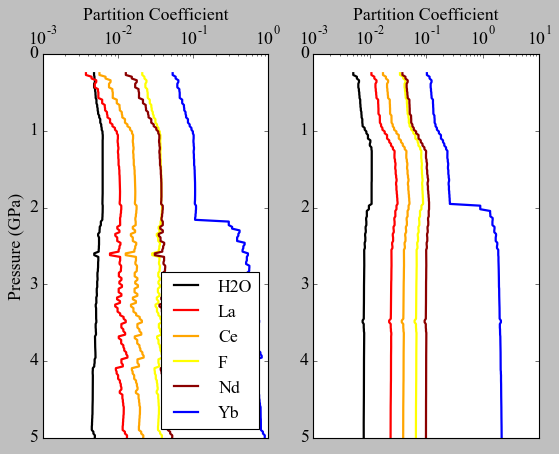

In [8]:
lz = m.LithologyKLB1()
px = m.LithologyKG1()
hz = m.LithologyNonMelting()

Tp=1400
FracPyx=0.1

mantle = m.mantle([lz,px,hz],[1-FracPyx,FracPyx,0],['Lz', 'Px', 'Hz'])
steps=251
column = mantle.AdiabaticMelt_1D(Tp,Pstart=6,Pend=0.25,steps=steps)

Cfinal, Cfinal_C, CT, D, DE = TraceCalc(column,Dsource=1,Esource=2,Ur=0,Xd=1-FracPyx,KLB=KLB,KG1=KG1)

# plot results
fig5, ((ax5a),(ax5b)) = plt.subplots(1, 2, figsize=(8,6))

ax5a.plot(D['H2O'],column.P,'-k',label="H2O",linewidth=2)
ax5a.plot(D['La'],column.P,'-r',label="La",linewidth=2)
ax5a.plot(D['Ce'],column.P,'-',label="Ce",linewidth=2,color='orange')
ax5a.plot(D['F'],column.P,'-',label="F",linewidth=2,color="yellow")
ax5a.plot(D['Nd'],column.P,'-',label="Nd",linewidth=2,color="darkred")
ax5a.plot(D['Yb'],column.P,'-',label="Yb",linewidth=2,color="blue")

ax5b.plot(DE['H2O'],column.P,'-k',label="H2O",linewidth=2)
ax5b.plot(DE['La'],column.P,'-r',label="La",linewidth=2)
ax5b.plot(DE['Ce'],column.P,'-',label="Ce",linewidth=2,color='orange')
ax5b.plot(DE['F'],column.P,'-',label="F",linewidth=2,color="yellow")
ax5b.plot(DE['Nd'],column.P,'-',label="Nd",linewidth=2,color="darkred")
ax5b.plot(DE['Yb'],column.P,'-',label="Yb",linewidth=2,color="blue")

ax5a.set_ylim([5,0])
ax5a.xaxis.tick_top()
ax5a.set_xlabel('Partition Coefficient')
ax5a.xaxis.set_label_position('top')
ax5a.set_ylabel('Pressure (GPa)')
ax5a.legend(loc='lower right', fontsize=16)
ax5a.set_xscale("log")

ax5b.set_ylim([5,0])
ax5b.xaxis.tick_top()
ax5b.set_xlabel('Partition Coefficient')
ax5b.xaxis.set_label_position('top')
ax5b.set_xscale("log")

# Recreating figures in the main text

## Figure 2

Here we display the relationship between volatile and non-volatile trace elements (e.g. H2O/La) and indices of enrichment. The composition of the GSC basalts are shown and colour-coded according to location. In the bottom left panel two separate models are shown, displaying the influence of increasing the fraction of channelised melt to the GSC on the H2O/La ratio of the GSC basalts (the H2O content of the GSC basalts has been corrected for the infleunce of brine assimilation). In both models shown in the bottom left panel, the H2O content of the pyroxenitic component is set at 320 ppm, and the pressure of channel initiation is set at 3.4 GPa in a plume stem with $T_p = 1400^{o}C$ (this value was chosen based on the results shown in Fig. 7 of the main text and represents the value that provides the best match to the along-ridge GSC data in Fig. 5). The main difference between the two models represents the composition of the peridotitic component. The solid line represents the case when the depleted endmember has the trace element composition of the DMM (Workman and Hart, 2005) and the dashed line represents a model where this peridotitic component is a 90:10 mixture of the DMM and the enriched mantle component of Donnelly et al. (2004). The results of the same models are shown in the bottom right panel, where the pyroxenitic component has a F content of 60 ppm.

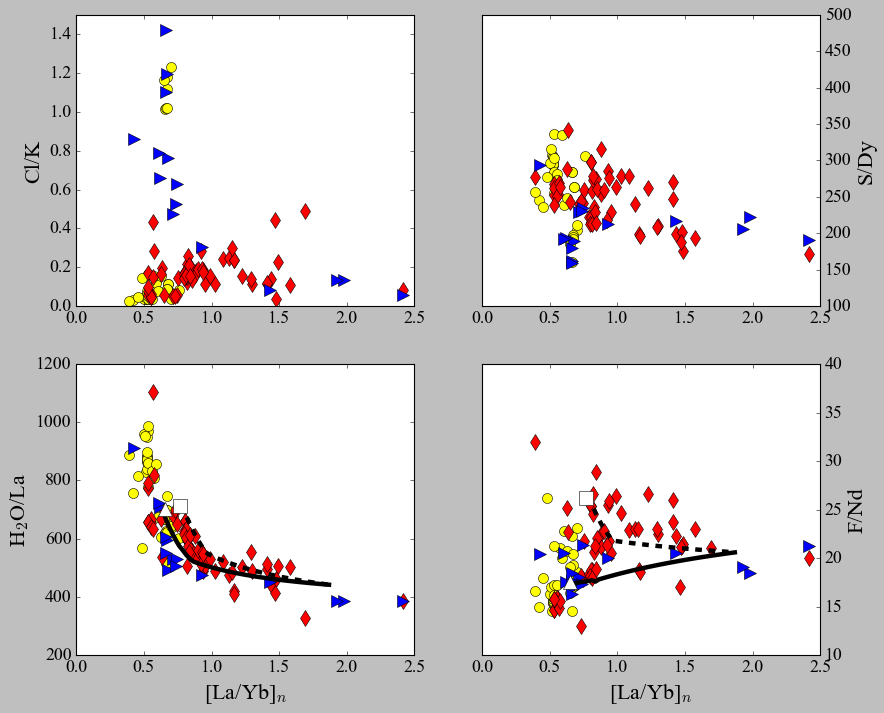

In [9]:
# run calculations to match volatile compositions
Data=pd.read_excel('Data/GSCdataset_PT.xlsx')
norm={'Rb': 0.635, 'Ba': 6.989, 'Th': 0.085, 'U': 0.021, 'Nb': 0.713, 'Ta': 0.041, 'La': 0.687, 'Ce': 1.775, 'Pb': 0.071, 'Pr': 0.276, 'Sr': 21.1, 'Nd': 1.354, 'Zr': 11.2, 'Hf': 0.309, 'Sm': 0.444, 'Eu': 0.168, 'Gd': 0.596, 'Tb': 0.108, 'Dy': 0.737, 'Ho': 0.164, 'Er': 0.48, 'Yb': 0.493, 'Y': 4.55, 'Lu': 0.074, 'H2O': 350, 'F': 30}

ClK=Data['Cl']/(Data['K2O']*10000*78/94)
Clpred=0.08*(Data['K2O']*10000*78/94)
Classim=Data['Cl']-Clpred
Hassim=0.61*Classim
Data['Hreal']=10000*Data['H2O']-Hassim

lz = m.LithologyKLB1()
px = m.LithologyKG1()
hz = m.LithologyNonMelting()

# prior to ridge melting calculation calc the composition of melts formed in the Galapagos plume stem

mantle = m.mantle([lz,px,hz],[1-0.4,0.4,0],['Lz', 'Px', 'Hz'])
steps=201
column = mantle.AdiabaticMelt_1D(1400,Pstart=6,Pend=1.8,steps=steps)

C_channel=Channel(column, Esource=2, KG1=KG1, Pchannel=3.4)

fig6, ((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2,2, figsize=(12,10))
ax6a.plot((Data['La'][(Data['Long']<85.5) | (Data['Long']>95.5)]/norm['La'])/(Data['Sm'][(Data['Long']<85.5) | (Data['Long']>95.5)]/norm['Sm']),Data['Cl'][(Data['Long']<85.5) | (Data['Long']>95.5)]/(10000*78/94*Data['K2O'][(Data['Long']<85.5) | (Data['Long']>95.5)]),'ok',markersize=9,markerfacecolor='yellow')
ax6a.plot((Data['La'][(Data['Long']<95.5) & (Data['Long']>90.8)]/norm['La'])/(Data['Sm'][(Data['Long']<95.5) & (Data['Long']>90.8)]/norm['Sm']),Data['Cl'][(Data['Long']<95.5) & (Data['Long']>90.8)]/(10000*78/94*Data['K2O'][(Data['Long']<95.5) & (Data['Long']>90.8)]),'dk',markersize=10,markerfacecolor='red')
ax6a.plot((Data['La'][(Data['Long']>85.5) & (Data['Long']<90.8)]/norm['La'])/(Data['Sm'][(Data['Long']>85.5) & (Data['Long']<90.8)]/norm['Sm']),Data['Cl'][(Data['Long']>85.5) & (Data['Long']<90.8)]/(10000*78/94*Data['K2O'][(Data['Long']>85.5) & (Data['Long']<90.8)]),'>k',markersize=10,markerfacecolor='blue')
ax6a.set_ylabel('Cl/K',fontsize=20)
ax6a.set_xlim([0,2.5])
ax6a.set_ylim([0,1.5])

ax6b.plot((Data['La'][(Data['Long']<85.5) | (Data['Long']>95.5)]/norm['La'])/(Data['Sm'][(Data['Long']<85.5) | (Data['Long']>95.5)]/norm['Sm']),Data['S'][(Data['Long']<85.5) | (Data['Long']>95.5)]/(Data['Dy'][(Data['Long']<85.5) | (Data['Long']>95.5)]),'ok',markersize=9,markerfacecolor='yellow')
ax6b.plot((Data['La'][(Data['Long']<95.5) & (Data['Long']>90.8)]/norm['La'])/(Data['Sm'][(Data['Long']<95.5) & (Data['Long']>90.8)]/norm['Sm']),Data['S'][(Data['Long']<95.5) & (Data['Long']>90.8)]/(Data['Dy'][(Data['Long']<95.5) & (Data['Long']>90.8)]),'dk',markersize=10,markerfacecolor='red')
ax6b.plot((Data['La'][(Data['Long']>85.5) & (Data['Long']<90.8)]/norm['La'])/(Data['Sm'][(Data['Long']>85.5) & (Data['Long']<90.8)]/norm['Sm']),Data['S'][(Data['Long']>85.5) & (Data['Long']<90.8)]/(Data['Dy'][(Data['Long']>85.5) & (Data['Long']<90.8)]),'>k',markersize=10,markerfacecolor='blue')
ax6b.set_ylabel('S/Dy',fontsize=20)
ax6b.yaxis.set_label_position("right")
ax6b.yaxis.tick_right()
ax6b.set_xlim([0,2.5])
ax6b.set_ylim([100,500])

ax6c.plot((Data['La'][(Data['Long']<85.5) | (Data['Long']>95.5)]/norm['La'])/(Data['Sm'][(Data['Long']<85.5) | (Data['Long']>95.5)]/norm['Sm']),Data['Hreal'][(Data['Long']<85.5) | (Data['Long']>95.5)]/(Data['La'][(Data['Long']<85.5) | (Data['Long']>95.5)]),'ok',markersize=9,markerfacecolor='yellow')
ax6c.plot((Data['La'][(Data['Long']<95.5) & (Data['Long']>90.8)]/norm['La'])/(Data['Sm'][(Data['Long']<95.5) & (Data['Long']>90.8)]/norm['Sm']),Data['Hreal'][(Data['Long']<95.5) & (Data['Long']>90.8)]/(Data['La'][(Data['Long']<95.5) & (Data['Long']>90.8)]),'dk',markersize=10,markerfacecolor='red')
ax6c.plot((Data['La'][(Data['Long']>85.5) & (Data['Long']<90.8)]/norm['La'])/(Data['Sm'][(Data['Long']>85.5) & (Data['Long']<90.8)]/norm['Sm']),Data['Hreal'][(Data['Long']>85.5) & (Data['Long']<90.8)]/(Data['La'][(Data['Long']>85.5) & (Data['Long']<90.8)]),'>k',markersize=10,markerfacecolor='blue')
ax6c.set_xlabel('[La/Yb]$_n$',fontsize=20)
ax6c.set_ylabel('H$_2$O/La',fontsize=20)
ax6c.set_xlim([0,2.5])
ax6c.set_ylim([200,1200])

ax6d.plot((Data['La'][(Data['Long']<85.5) | (Data['Long']>95.5)]/norm['La'])/(Data['Sm'][(Data['Long']<85.5) | (Data['Long']>95.5)]/norm['Sm']),Data['F'][(Data['Long']<85.5) | (Data['Long']>95.5)]/(Data['Nd'][(Data['Long']<85.5) | (Data['Long']>95.5)]),'ok',markersize=9,markerfacecolor='yellow')
ax6d.plot((Data['La'][(Data['Long']<95.5) & (Data['Long']>90.8)]/norm['La'])/(Data['Sm'][(Data['Long']<95.5) & (Data['Long']>90.8)]/norm['Sm']),Data['F'][(Data['Long']<95.5) & (Data['Long']>90.8)]/(Data['Nd'][(Data['Long']<95.5) & (Data['Long']>90.8)]),'dk',markersize=10,markerfacecolor='red')
ax6d.plot((Data['La'][(Data['Long']>85.5) & (Data['Long']<90.8)]/norm['La'])/(Data['Sm'][(Data['Long']>85.5) & (Data['Long']<90.8)]/norm['Sm']),Data['F'][(Data['Long']>85.5) & (Data['Long']<90.8)]/(Data['Nd'][(Data['Long']>85.5) & (Data['Long']<90.8)]),'>k',markersize=10,markerfacecolor='blue')
ax6d.set_xlabel('[La/Yb]$_n$',fontsize=20)
ax6d.set_ylabel('F/Nd',fontsize=20)
ax6d.yaxis.set_label_position("right")
ax6d.yaxis.tick_right()
ax6d.set_xlim([0,2.5])
ax6d.set_ylim([10,40])

num=100
H2O=np.zeros(num)
F=np.zeros(num)
La=np.zeros(num)
Nd=np.zeros(num)
Sm=np.zeros(num)
Yb=np.zeros(num)

a=np.zeros(1)
b=np.linspace(0,0.99,99)
c=np.concatenate((a,b))

a=np.linspace(0.02,0.08,10)
b=np.zeros(90)+0.08
FracPyx=np.concatenate((a,b))

for uuu in range(0,num):
    mantle = m.mantle([lz,px,hz],[1-FracPyx[uuu],FracPyx[uuu],0],['Lz', 'Px', 'Hz'])
    steps=251
    column = mantle.AdiabaticMelt_1D(1360,Pstart=6,Pend=0.25,steps=steps)
    BBB=next(x for x, val in enumerate(column.F.Lz) if val>0)

    Cfinal, Cfinal_C, CT, D, DE = TraceCalc(column,Dsource=1,Esource=2,Ur=1.5,Xd=1-FracPyx[uuu],Ffactor=0.7,KLB=KLB,KG1=KG1)
    
    Cfinal=Cfinal*(1-c[uuu])+c[uuu]*C_channel
    
    H2O[uuu]=Cfinal[-2]
    F[uuu]=Cfinal[-1]
    La[uuu]=Cfinal[2]
    Nd[uuu]=Cfinal[5]
    Sm[uuu]=Cfinal[6]
    Yb[uuu]=Cfinal[-4]
    

ax6c.plot((La/norm['La'])/(Sm/norm['Sm']),H2O/La,'-k',linewidth=4)
ax6c.plot((La[0]/norm['La'])/(Sm[0]/norm['Sm']),H2O[0]/La[0],'^k',markersize=12,markerfacecolor='white')

ax6d.plot((La/norm['La'])/(Sm/norm['Sm']),F/Nd,'-k',linewidth=4)
ax6d.plot((La[0]/norm['La'])/(Sm[0]/norm['Sm']),F[0]/Nd[0],'^k',markersize=12,markerfacecolor='white')

num=100
H2O=np.zeros(num)
F=np.zeros(num)
La=np.zeros(num)
Nd=np.zeros(num)
Sm=np.zeros(num)
Yb=np.zeros(num)

a=np.zeros(1)
b=np.linspace(0.02,0.99,99)
c=np.concatenate((a,b))

a=np.linspace(0.02,0.06,10)
b=np.zeros(90)+0.06
FracPyx=np.concatenate((a,b))

for uuu in range(0,num):
    mantle = m.mantle([lz,px,hz],[1-FracPyx[uuu],FracPyx[uuu],0],['Lz', 'Px', 'Hz'])
    steps=251
    column = mantle.AdiabaticMelt_1D(1360,Pstart=6,Pend=0.25,steps=steps)
    BBB=next(x for x, val in enumerate(column.F.Lz) if val>0)

    Cfinal, Cfinal_C, CT, D, DE = TraceCalc(column,Dsource=2,Esource=2,Ur=1.5,Xd=1-FracPyx[uuu],Ffactor=0.7,KLB=KLB,KG1=KG1)
    
    Cfinal=Cfinal*(1-c[uuu])+c[uuu]*C_channel
    
    H2O[uuu]=Cfinal[-2]
    F[uuu]=Cfinal[-1]
    La[uuu]=Cfinal[2]
    Nd[uuu]=Cfinal[5]
    Sm[uuu]=Cfinal[6]
    Yb[uuu]=Cfinal[-4]
    

ax6c.plot((La/norm['La'])/(Sm/norm['Sm']),H2O/La,'--k',linewidth=4)
ax6c.plot((La[0]/norm['La'])/(Sm[0]/norm['Sm']),H2O[0]/La[0],'sk',markersize=12,markerfacecolor='white')

ax6d.plot((La/norm['La'])/(Sm/norm['Sm']),F/Nd,'--k',linewidth=4)
ax6d.plot((La[0]/norm['La'])/(Sm[0]/norm['Sm']),F[0]/Nd[0],'sk',markersize=12,markerfacecolor='white')


## Figure 4 - eastern GSC

The following calculations were used to create panels D, E, and F of Figure 4 in the main text (i.e. solid-state plume-ridge interaction models for the eastern GSC.

*Please note that this may take several minutes to run if the number of calculations (num) and the number of steps are kept high. If you wish to quickly run a model to test the influence of changing a single parameter I'd suggest changing the value of num to ~20.*

In [10]:
# run calculations (solid-state) for the eastern GSC
Data=pd.read_excel('Data/GSCcorrectedFinal.xlsx')
EGSC=Data.copy()
EGSC=EGSC[EGSC['Region']=="EGSC"]

norm={'Rb': 0.635, 'Ba': 6.989, 'Th': 0.085, 'U': 0.021, 'Nb': 0.713, 'Ta': 0.041, 'La': 0.687, 'Ce': 1.775, 'Pb': 0.071, 'Pr': 0.276, 'Sr': 21.1, 'Nd': 1.354, 'Zr': 11.2, 'Hf': 0.309, 'Sm': 0.444, 'Eu': 0.168, 'Gd': 0.596, 'Tb': 0.108, 'Dy': 0.737, 'Ho': 0.164, 'Er': 0.48, 'Yb': 0.493, 'Y': 4.55, 'Lu': 0.074, 'H2O': 350, 'F': 30}

lz = m.LithologyKLB1()
px = m.LithologyKG1()
hz = m.LithologyNonMelting()

num=101
Longplot=np.zeros(num)
Ur=np.zeros(num)
Tp=np.zeros(num)
FracPyx=np.zeros(num)
dtop=np.zeros(num)
LaYb=np.zeros(num)
CT=np.zeros(num)
H2O=np.zeros(num)

for uuu in range(0,num):
    Longplot[uuu]=(uuu)*(90.8-86)/num+86
    Ur[uuu]=np.exp(-((90.8-Longplot[uuu])*0.5))*7
    Tp[uuu]=(2/num)*(uuu)+1360

    FracPyx[uuu]=np.exp(-((90.8-Longplot[uuu])*0.4))*0.12+0.04

    dtop[uuu]=np.exp(-((90.8-Longplot[uuu])*1))*0.85+0.25

    mantle = m.mantle([lz,px,hz],[1-FracPyx[uuu],FracPyx[uuu],0],['Lz', 'Px', 'Hz'])
    steps=251
    column = mantle.AdiabaticMelt_1D(Tp[uuu],Pstart=6,Pend=dtop[uuu],steps=steps)
    BBB=next(x for x, val in enumerate(column.F.Lz) if val>0)

    Cfinal, Cfinal_C, CT[uuu], D, DE = TraceCalc(column,Dsource=1,Esource=2,Ur=Ur[uuu],Xd=1-FracPyx[uuu],Ffactor=0.7,KLB=KLB,KG1=KG1)

    LaYb[uuu]=(Cfinal[2]/norm['La'])/(Cfinal[-4]/norm['Yb'])
    
    H2O[uuu]=Cfinal[-2]

In this first figure, we recreate the plots seen in Fig. 4 of the main text. The maximum relative flow velocity of the solid mantle leaving the melting region is shown in the top panel and represents the main control on the composition of erupted basalts and the crustal thickness of the crust produced. However, secondary factors, such as the pressure at which melting terminates and the mantle potential temperature beneath the ridge also play a role (see below).

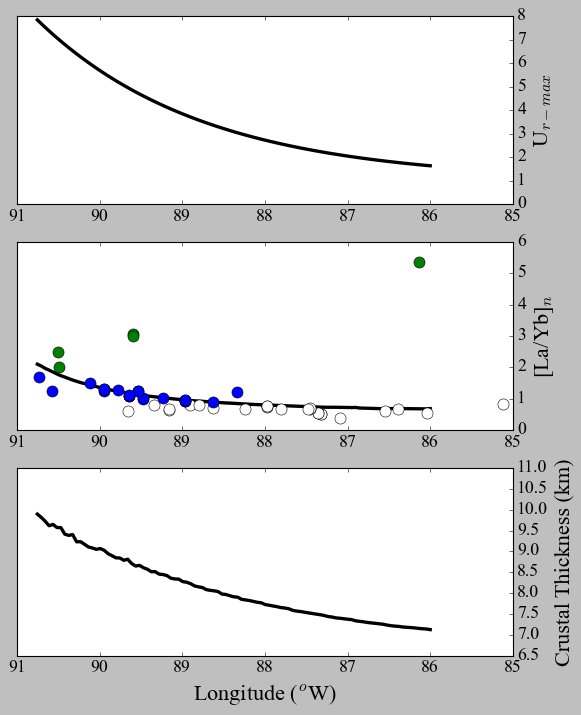

In [11]:
# plot results for the EGSC (solid-state models)
fig7, ((ax7a,ax7b,ax7c)) = plt.subplots(3,1, figsize=(8,10))
ax7a.plot(Longplot,Ur+1,'-k',linewidth=3)
ax7a.set_xlim([91,85])
ax7a.set_ylim([0,8])
ax7a.set_ylabel('U$_{r-max}$',fontsize=20)
ax7a.yaxis.set_label_position("right")
ax7a.yaxis.tick_right()

ax7b.plot(Longplot,LaYb,'-k',linewidth=3)
ax7b.plot(-1*EGSC['Long'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<0.8],(EGSC['La'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<0.8]/norm['La'])/(EGSC['Yb'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<0.8]/norm['Yb']),'ok',markerfacecolor="white",markersize=10)
ax7b.plot(-1*EGSC['Long'][((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>0.8) & ((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<1.2)],(EGSC['La'][((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>0.8) & ((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<1.2)]/norm['La'])/(EGSC['Yb'][((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>0.8) & ((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<1.2)]/norm['Yb']),'ok',markerfacecolor="blue",markersize=10)
ax7b.plot(-1*EGSC['Long'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>1.2],(EGSC['La'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>1.2]/norm['La'])/(EGSC['Yb'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>1.2]/norm['Yb']),'ok',markerfacecolor="green",markersize=10)
ax7b.set_xlim([91,85])
ax7b.set_ylim([0,6])
ax7b.set_ylabel('[La/Yb]$_n$',fontsize=20)
ax7b.yaxis.set_label_position("right")
ax7b.yaxis.tick_right()

ax7c.plot(Longplot,CT/1000,'-k',linewidth=3)
ax7c.set_xlim([91,85])
ax7c.set_ylim([6.5,11])
ax7c.set_ylabel('Crustal Thickness (km)',fontsize=20)
ax7c.set_xlabel('Longitude ($^o$W)',fontsize=20)
ax7c.yaxis.set_label_position("right")
ax7c.yaxis.tick_right()

This second figure displays the proportion of pyroxenitic material in the mantle source, the mantle potential temperature beneath the ridge axis and the pressure at which melting terminates. One critical factor is the increase in the pressure of melt termination as the GTF is approached. This could  be due to conductive cooling effects near the transform fault (Le Voyer et al. 2015) and is required to stop a 'run-away' increase in the crustal thickness of the oceanic crust produced near the ridge axis.

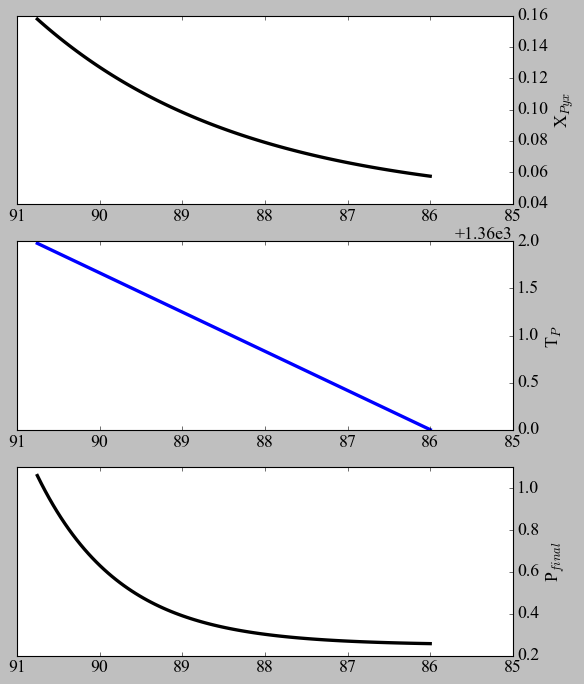

In [12]:
fig8, ((ax8a,ax8b,ax8c)) = plt.subplots(3,1, figsize=(8,10))
ax8a.plot(Longplot,FracPyx,'-k',linewidth=3)
ax8a.set_xlim([91,85])
ax8a.set_ylabel('X$_{Pyx}$')
ax8a.yaxis.set_label_position("right")
ax8a.yaxis.tick_right()

ax8b.plot(Longplot,Tp,linewidth=3)
ax8b.set_xlim([91,85])
ax8b.set_ylabel('T$_P$')
ax8b.yaxis.set_label_position("right")
ax8b.yaxis.tick_right()

ax8c.plot(Longplot,dtop,'-k',linewidth=3)
ax8c.set_xlim([91,85])
ax8c.set_ylabel('P$_{final}$')
ax8c.yaxis.set_label_position("right")
ax8c.yaxis.tick_right()

## Figure 4 - western GSC

The following code was used to create panels A - C in Figure 4 of the main text. In other words, the following models describe the composition and crustal thickness of the ridge predicted by models that invoke an along-ridge gradient in the maximum flow rate of material out of the melting region (owing to the excess buoyancy flux of the plume material). The two plotting scripts below once again represent the graphs displayed in the main text, and additional graphs showing the variation in secondary parameters, respectively.

In [13]:
# run calculations (solid-state) for the western GSC
Data=pd.read_excel('Data/GSCcorrectedFinal.xlsx')
WGSC=Data.copy()
WGSC=WGSC[WGSC['Region']=="WGSC"]
WGSC=WGSC[WGSC['Long']>-95.5]

norm={'Rb': 0.635, 'Ba': 6.989, 'Th': 0.085, 'U': 0.021, 'Nb': 0.713, 'Ta': 0.041, 'La': 0.687, 'Ce': 1.775, 'Pb': 0.071, 'Pr': 0.276, 'Sr': 21.1, 'Nd': 1.354, 'Zr': 11.2, 'Hf': 0.309, 'Sm': 0.444, 'Eu': 0.168, 'Gd': 0.596, 'Tb': 0.108, 'Dy': 0.737, 'Ho': 0.164, 'Er': 0.48, 'Yb': 0.493, 'Y': 4.55, 'Lu': 0.074, 'H2O': 350, 'F': 30}

lz = m.LithologyKLB1()
px = m.LithologyKG1()
hz = m.LithologyNonMelting()



num=101
Longplot=np.zeros(num)
Ur=np.zeros(num)
Tp=np.zeros(num)
FracPyx=np.zeros(num)
dtop=np.zeros(num)
LaYb=np.zeros(num)
CT=np.zeros(num)
H2O=np.zeros(num)

for uuu in range(0,num):
    Longplot[uuu]=(uuu)*(90.8-95.5)/num+95.5
    Ur[uuu]=np.exp(-((Longplot[uuu]-90.8)*0.6))*6
    Tp[uuu]=(4/num)*(uuu)+1358

    FracPyx[uuu]=np.exp(-((Longplot[uuu]-90.8)*0.4))*0.12+0.03

    dtop[uuu]=np.exp(-((Longplot[uuu]-90.8)*1))*0.85+0.25

    mantle = m.mantle([lz,px,hz],[1-FracPyx[uuu],FracPyx[uuu],0],['Lz', 'Px', 'Hz'])
    steps=251
    column = mantle.AdiabaticMelt_1D(Tp[uuu],Pstart=6,Pend=dtop[uuu],steps=steps)
    BBB=next(x for x, val in enumerate(column.F.Lz) if val>0)

    Cfinal, Cfinal_C, CT[uuu], D, DE = TraceCalc(column,Dsource=2,Esource=2,Ur=Ur[uuu],Xd=1-FracPyx[uuu],Ffactor=0.7,KLB=KLB,KG1=KG1)

    LaYb[uuu]=(Cfinal[2]/norm['La'])/(Cfinal[-4]/norm['Yb'])
    
    H2O[uuu]=Cfinal[-2]

Text(0.5, 0, 'Longitude ($^o$W)')

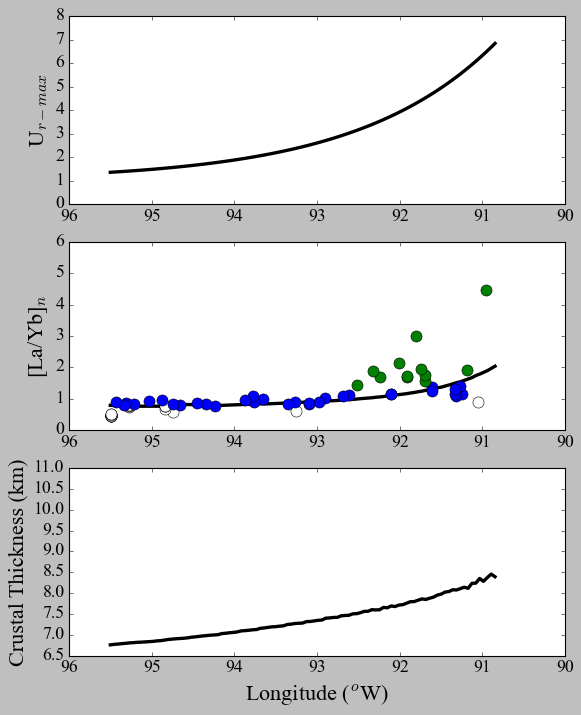

In [14]:
# plot results for the EGSC (solid-state models)
fig9, ((ax9a,ax9b,ax9c)) = plt.subplots(3,1, figsize=(8,10))
ax9a.plot(Longplot,Ur+1,'-k',linewidth=3)
ax9a.set_xlim([96,90])
ax9a.set_ylim([0,8])
ax9a.set_ylabel('U$_{r-max}$',fontsize=20)

ax9b.plot(Longplot,LaYb,'-k',linewidth=3)
ax9b.plot(-1*WGSC['Long'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<0.8],(WGSC['La'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<0.8]/norm['La'])/(WGSC['Yb'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<0.8]/norm['Yb']),'ok',markerfacecolor="white",markersize=10)
ax9b.plot(-1*WGSC['Long'][((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>0.8) & ((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<1.2)],(WGSC['La'][((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>0.8) & ((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<1.2)]/norm['La'])/(WGSC['Yb'][((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>0.8) & ((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<1.2)]/norm['Yb']),'ok',markerfacecolor="blue",markersize=10)
ax9b.plot(-1*WGSC['Long'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>1.2],(WGSC['La'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>1.2]/norm['La'])/(WGSC['Yb'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>1.2]/norm['Yb']),'ok',markerfacecolor="green",markersize=10)
ax9b.set_xlim([96,90])
ax9b.set_ylim([0,6])
ax9b.set_ylabel('[La/Yb]$_n$',fontsize=20)

ax9c.plot(Longplot,CT/1000,'-k',linewidth=3)
ax9c.set_xlim([96,90])
ax9c.set_ylim([6.5,11])
ax9c.set_ylabel('Crustal Thickness (km)',fontsize=20)
ax9c.set_xlabel('Longitude ($^o$W)',fontsize=20)

Text(0, 0.5, 'P$_{final}$')

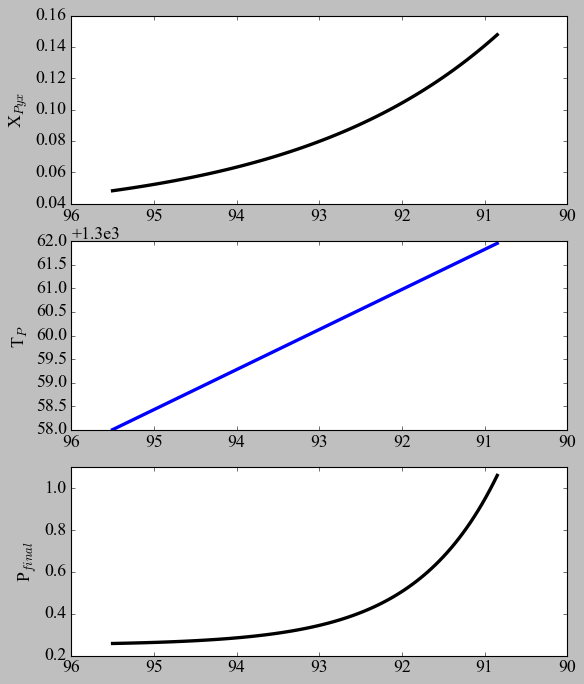

In [15]:
fig10, ((ax10a,ax10b,ax10c)) = plt.subplots(3,1, figsize=(8,10))
ax10a.plot(Longplot,FracPyx,'-k',linewidth=3)
ax10a.set_xlim([96,90])
ax10a.set_ylabel('X$_{Pyx}$')

ax10b.plot(Longplot,Tp,linewidth=3)
ax10b.set_xlim([96,90])
ax10b.set_ylabel('T$_P$')

ax10c.plot(Longplot,dtop,'-k',linewidth=3)
ax10c.set_xlim([96,90])
ax10c.set_ylabel('P$_{final}$')

## The influence of melt channelisation (Figs. 5 & 9)

In the following calculations we reproduce figures 5 and 9 from the main text of Gleeson and Gibson (2021). These figures demonstrate the geochemical and geophysical consequences of melt transport between the Galapagos mantle plume and the Galapagos Spreading Centre.

First, we start with the eastern GSC and show how a steadily decreasing supply of channelised, plume-derived melts to the eastern GSC with increasing plume-ridge distance can recreate the features seen there. As with the code for Fig. 2 above, the pressure of melt channelisation is set to 3.4 GPa.

In [16]:
# model EGSC again but use channelised melt flow instead of dynamic upwelling
Data=pd.read_excel('Data/GSCcorrectedFinal.xlsx')
EGSC=Data.copy()
EGSC=EGSC[EGSC['Region']=="EGSC"]

norm={'Rb': 0.635, 'Ba': 6.989, 'Th': 0.085, 'U': 0.021, 'Nb': 0.713, 'Ta': 0.041, 'La': 0.687, 'Ce': 1.775, 'Pb': 0.071, 'Pr': 0.276, 'Sr': 21.1, 'Nd': 1.354, 'Zr': 11.2, 'Hf': 0.309, 'Sm': 0.444, 'Eu': 0.168, 'Gd': 0.596, 'Tb': 0.108, 'Dy': 0.737, 'Ho': 0.164, 'Er': 0.48, 'Yb': 0.493, 'Y': 4.55, 'Lu': 0.074, 'H2O': 350, 'F': 30}

lz = m.LithologyKLB1()
px = m.LithologyKG1()
hz = m.LithologyNonMelting()

# prior to ridge melting calculation calc the composition of melts formed in the Galapagos plume stem

mantle = m.mantle([lz,px,hz],[1-0.4,0.4,0],['Lz', 'Px', 'Hz'])
steps=201
column = mantle.AdiabaticMelt_1D(1400,Pstart=6,Pend=1.8,steps=steps)

C_channel=Channel(column, Esource=2, KG1=KG1, Pchannel=3.4)

num=101
Longplot=np.zeros(num)
Ur=np.zeros(num)
Tp=np.zeros(num)
FracPyx=np.zeros(num)
dtop=np.zeros(num)
LaYb=np.zeros(num)
CT=np.zeros(num)
H2O=np.zeros(num)
H2O_C=np.zeros(num)
c=np.zeros(num)

for uuu in range(0,num):
    Longplot[uuu]=(uuu)*(90.8-86)/num+86
    Ur[uuu]=np.exp(-((90.8-Longplot[uuu])*0.4))*2
    Tp[uuu]=(20/num)*(uuu-1)+1365
    c[uuu]=np.exp(-((90.8 - Longplot[uuu])*1))*0.22

    FracPyx[uuu]=np.exp(-((90.8-Longplot[uuu])*0.8))*0.04+0.04

    dtop[uuu]=np.exp(-((90.8-Longplot[uuu])*1.4))*0.3+0.25

    mantle = m.mantle([lz,px,hz],[1-FracPyx[uuu],FracPyx[uuu],0],['Lz', 'Px', 'Hz'])
    steps=251
    column = mantle.AdiabaticMelt_1D(Tp[uuu],Pstart=6,Pend=dtop[uuu],steps=steps)
    BBB=next(x for x, val in enumerate(column.F.Lz) if val>0)

    Cfinal, Cfinal_C, CT[uuu], D, DE = TraceCalc(column,Dsource=1,Esource=2,Ur=Ur[uuu],Xd=1-FracPyx[uuu],Ffactor=0.7,KLB=KLB,KG1=KG1)
    
    Cfinal=Cfinal*(1-c[uuu])+c[uuu]*C_channel
    CT[uuu]=CT[uuu]/(1-c[uuu])
    
    LaYb[uuu]=(Cfinal[2]/norm['La'])/(Cfinal[-4]/norm['Yb'])
    
    H2O[uuu]=Cfinal[-2]
    H2O_C[uuu]=(C_channel[-2]*c[uuu])/(Cfinal[-2]*(1-c[uuu])+c[uuu]*C_channel[-2])

(6.0, 11.0)

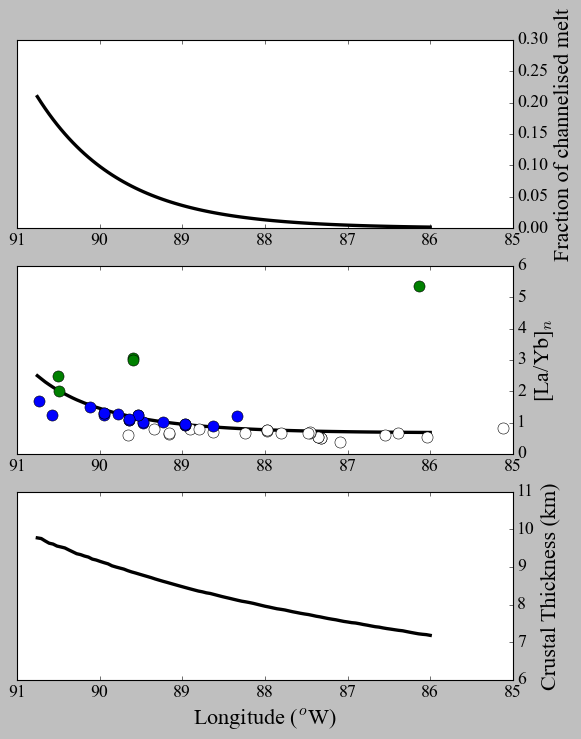

In [17]:
# plot results for the EGSC
fig11, ((ax11a,ax11b,ax11c)) = plt.subplots(3,1, figsize=(8,10))
ax11a.plot(Longplot,c,'-k',linewidth=3)
ax11a.set_xlim([91,85])
ax11a.set_ylabel('Fraction of channelised melt',fontsize=20)
ax11a.yaxis.set_label_position("right")
ax11a.yaxis.tick_right()
ax11a.set_ylim([0,0.3])

ax11b.plot(Longplot,LaYb,'-k',linewidth=3)
ax11b.plot(-1*EGSC['Long'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<0.8],(EGSC['La'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<0.8]/norm['La'])/(EGSC['Yb'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<0.8]/norm['Yb']),'ok',markerfacecolor="white",markersize=10)
ax11b.plot(-1*EGSC['Long'][((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>0.8) & ((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<1.2)],(EGSC['La'][((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>0.8) & ((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<1.2)]/norm['La'])/(EGSC['Yb'][((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>0.8) & ((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<1.2)]/norm['Yb']),'ok',markerfacecolor="blue",markersize=10)
ax11b.plot(-1*EGSC['Long'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>1.2],(EGSC['La'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>1.2]/norm['La'])/(EGSC['Yb'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>1.2]/norm['Yb']),'ok',markerfacecolor="green",markersize=10)
ax11b.set_xlim([91,85])
ax11b.set_ylabel('[La/Yb]$_n$',fontsize=20)
ax11b.yaxis.set_label_position("right")
ax11b.yaxis.tick_right()
ax11b.set_ylim([0,6])

ax11c.plot(Longplot,CT/1000,'-k',linewidth=3)
ax11c.set_xlim([91,85])
ax11c.set_ylabel('Crustal Thickness (km)',fontsize=20)
ax11c.set_xlabel('Longitude ($^o$W)',fontsize=20)
ax11c.yaxis.set_label_position("right")
ax11c.yaxis.tick_right()
ax11c.set_ylim([6,11])

Using these results, we can also calculate the flux of water out of the eastern GSC (see section 7 of the main text).

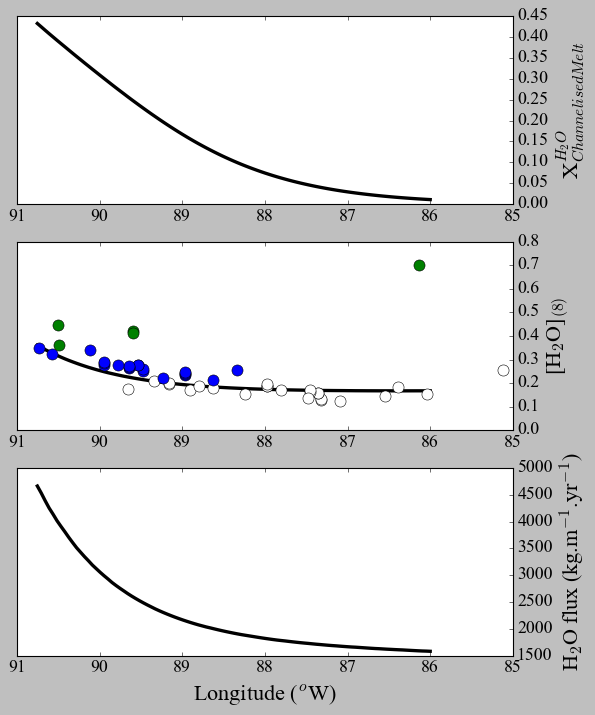

In [18]:
fig12, ((ax12a,ax12b,ax12c)) = plt.subplots(3,1, figsize=(8,10))
ax12a.plot(Longplot,H2O_C,'-k',linewidth=3)
ax12a.set_xlim([91,85])
ax12a.set_ylabel('X$^{H_2O}_{Channelised Melt}$', fontsize=20)
ax12a.yaxis.set_label_position("right")
ax12a.yaxis.tick_right()

ax12b.plot(Longplot,H2O/(10000*0.8),'-k',linewidth=3) # concentration assuming ~25% crystallisation prior to 8 wt% MgO
ax12b.plot(-1*EGSC['Long'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<0.8],(EGSC['H2Ofull'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<0.8]),'ok',markerfacecolor="white",markersize=10)
ax12b.plot(-1*EGSC['Long'][((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>0.8) & ((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<1.2)],(EGSC['H2Ofull'][((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>0.8) & ((EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])<1.2)]),'ok',markerfacecolor="blue",markersize=10)
ax12b.plot(-1*EGSC['Long'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>1.2],(EGSC['H2Ofull'][(EGSC['La']/norm['La'])/(EGSC['Sm']/norm['Sm'])>1.2]),'ok',markerfacecolor="green",markersize=10)
ax12b.set_xlim([91,85])
ax12b.set_ylim([0,0.8])
ax12b.set_ylabel('[H$_2$O]$_{(8)}$', fontsize=20)
ax12b.yaxis.set_label_position("right")
ax12b.yaxis.tick_right()

H2Oflux=(H2O*10**(-6))*CT*2900*0.057

ax12c.plot(Longplot,H2Oflux,'-k',linewidth=3)
ax12c.set_xlim([91,85])
ax12c.set_ylabel('H$_2$O flux (kg.m$^{-1}$.yr$^{-1}$)', fontsize=20)
ax12c.set_xlabel('Longitude ($^o$W)',fontsize=20)
ax12c.yaxis.set_label_position("right")
ax12c.yaxis.tick_right()

We can perform similar calculations for the western GSC, but in case case we find that the geochemical and geophysical data from this segment of ridge is best recreated when we model a low-level 'background flux' of channelised melt to the western GSC east of ~93$^o$W, which is then overprinted by three concentrated regions of high melt flux corresponding to the intersection of volcanic lineaments in the Northern Galapagos Volcanic Province with the western GSC.

In [19]:
# run calculations (melt-state) for the western GSC
Data=pd.read_excel('Data/GSCcorrectedFinal.xlsx')
WGSC=Data.copy()
WGSC=WGSC[WGSC['Region']=="WGSC"]
WGSC=WGSC[WGSC['Long']>-95.5]

norm={'Rb': 0.635, 'Ba': 6.989, 'Th': 0.085, 'U': 0.021, 'Nb': 0.713, 'Ta': 0.041, 'La': 0.687, 'Ce': 1.775, 'Pb': 0.071, 'Pr': 0.276, 'Sr': 21.1, 'Nd': 1.354, 'Zr': 11.2, 'Hf': 0.309, 'Sm': 0.444, 'Eu': 0.168, 'Gd': 0.596, 'Tb': 0.108, 'Dy': 0.737, 'Ho': 0.164, 'Er': 0.48, 'Yb': 0.493, 'Y': 4.55, 'Lu': 0.074, 'H2O': 350, 'F': 30}

lz = m.LithologyKLB1()
px = m.LithologyKG1()
hz = m.LithologyNonMelting()

# prior to ridge melting calculation calc the composition of melts formed in the Galapagos plume stem

mantle = m.mantle([lz,px,hz],[1-0.4,0.4,0],['Lz', 'Px', 'Hz'])
steps=201
column = mantle.AdiabaticMelt_1D(1400,Pstart=6,Pend=1.8,steps=steps)

C_channel=Channel(column, Esource=2, KG1=KG1, Pchannel=3.4)

num=251
Longplot=np.linspace(90.8,95.5,num)
Y=(1/(0.09*np.sqrt(2*(np.pi)))*np.exp((-(Longplot-92.25)**2)/(2*(0.09**2))))
Y2=(1/(0.09*np.sqrt(2*(np.pi)))*np.exp((-(Longplot-91.8)**2)/(2*(0.09**2))))
Y3=(1/(0.09*np.sqrt(2*(np.pi)))*np.exp((-(Longplot-91.3)**2)/(2*(0.09**2))))
Y4=(1/(0.6*np.sqrt(2*(np.pi)))*np.exp((-(Longplot-91.8)**2)/(2*(0.6**2))))
Ysum=0.9*Y+0.7*Y2+0.9*Y3
c=(Ysum/np.max(Ysum))*0.1+0.1*(Y4/np.max(Y4))
Ur=np.exp(-((Longplot-90.8)*0.6))*2.5
Tp=np.zeros(num)
FracPyx=np.exp(-((Longplot-90.8)*0.4))*0.04+0.02
dtop=np.exp(-((Longplot-90.8)*1.5))*0.150+0.25
LaYb=np.zeros(num)
CT=np.zeros(num)
H2O=np.zeros(num)
H2O_C=np.zeros(num)

for uuu in range(0,num):
    Tp[uuu]=1362-(2/num)*(uuu)

    mantle = m.mantle([lz,px,hz],[1-FracPyx[uuu],FracPyx[uuu],0],['Lz', 'Px', 'Hz'])
    steps=251
    column = mantle.AdiabaticMelt_1D(Tp[uuu],Pstart=6,Pend=dtop[uuu],steps=steps)
    BBB=next(x for x, val in enumerate(column.F.Lz) if val>0)

    Cfinal, Cfinal_C, CT[uuu], D, DE = TraceCalc(column,Dsource=2,Esource=2,Ur=Ur[uuu],Xd=1-FracPyx[uuu],Ffactor=0.7,KLB=KLB,KG1=KG1)
    
    Cfinal=Cfinal*(1-c[uuu])+c[uuu]*C_channel
    CT[uuu]=CT[uuu]/(1-c[uuu])
    
    LaYb[uuu]=(Cfinal[2]/norm['La'])/(Cfinal[-4]/norm['Yb'])
    
    H2O[uuu]=Cfinal[-2]
    H2O_C[uuu]=(C_channel[-2]*c[uuu])/(Cfinal[-2]*(1-c[uuu])+c[uuu]*C_channel[-2])

(6.5, 11.0)

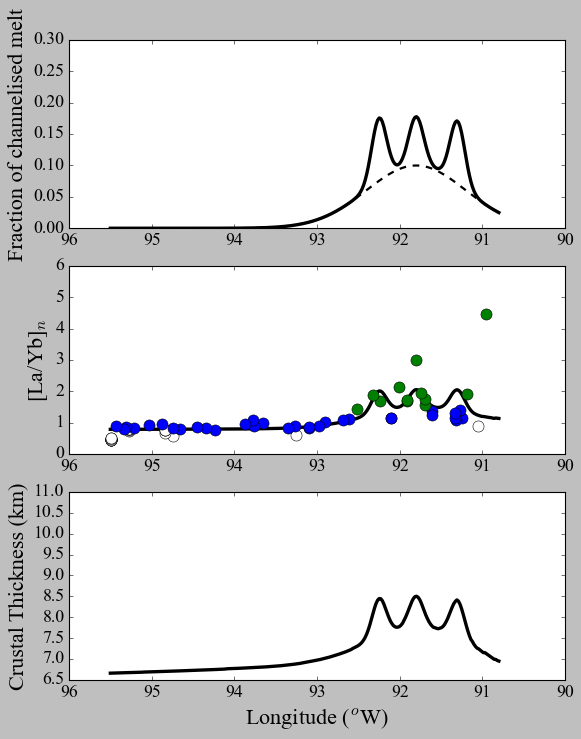

In [20]:
# plot results for the WGSC
fig13, ((ax13a,ax13b,ax13c)) = plt.subplots(3,1, figsize=(8,10))
ax13a.plot(Longplot,0.1*(Y4/np.max(Y4)),'--k',linewidth=2)
ax13a.plot(Longplot,c,'-k',linewidth=3)
ax13a.set_xlim([96,90])
ax13a.set_ylabel('Fraction of channelised melt',fontsize=20)
ax13a.set_ylim([0,0.30])

ax13b.plot(Longplot,LaYb,'-k',linewidth=3)
ax13b.plot(-1*WGSC['Long'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<0.8],(WGSC['La'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<0.8]/norm['La'])/(WGSC['Yb'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<0.8]/norm['Yb']),'ok',markerfacecolor="white",markersize=10)
ax13b.plot(-1*WGSC['Long'][((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>0.8) & ((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<1.2)],(WGSC['La'][((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>0.8) & ((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<1.2)]/norm['La'])/(WGSC['Yb'][((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>0.8) & ((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<1.2)]/norm['Yb']),'ok',markerfacecolor="blue",markersize=10)
ax13b.plot(-1*WGSC['Long'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>1.2],(WGSC['La'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>1.2]/norm['La'])/(WGSC['Yb'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>1.2]/norm['Yb']),'ok',markerfacecolor="green",markersize=10)
ax13b.set_xlim([96,90])
ax13b.set_ylabel('[La/Yb]$_n$',fontsize=20)
ax13b.set_ylim([0,6])

ax13c.plot(Longplot,CT/1000,'-k',linewidth=3)
ax13c.set_xlim([96,90])
ax13c.set_ylabel('Crustal Thickness (km)',fontsize=20)
ax13c.set_xlabel('Longitude ($^o$W)',fontsize=20)
ax13c.set_ylim([6.5,11])

As with the eastern GSC, we can use these results to estimate the flux of H$_2$O from the western GSC.

Text(0.5, 0, 'Longitude ($^o$W)')

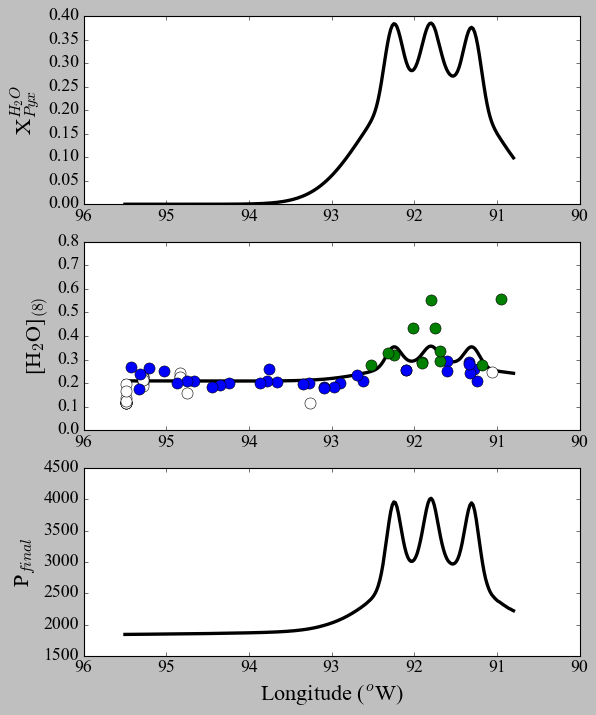

In [22]:
fig14, ((ax14a,ax14b,ax14c)) = plt.subplots(3,1, figsize=(8,10))
ax14a.plot(Longplot,H2O_C,'-k',linewidth=3)
ax14a.set_xlim([96,90])
ax14a.set_ylabel('X$_{Pyx}^{H_2O}$', fontsize=20)

ax14b.plot(Longplot,H2O/(10000*0.8),'-k',linewidth=3) # concentration assuming ~25% crystallisation prior to 8 wt% MgO
ax14b.plot(-1*WGSC['Long'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<0.8],(WGSC['H2Ofull'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<0.8]),'ok',markerfacecolor="white",markersize=10)
ax14b.plot(-1*WGSC['Long'][((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>0.8) & ((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<1.2)],(WGSC['H2Ofull'][((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>0.8) & ((WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])<1.2)]),'ok',markerfacecolor="blue",markersize=10)
ax14b.plot(-1*WGSC['Long'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>1.2],(WGSC['H2Ofull'][(WGSC['La']/norm['La'])/(WGSC['Sm']/norm['Sm'])>1.2]),'ok',markerfacecolor="green",markersize=10)
ax14b.set_xlim([96,90])
ax14b.set_ylim([0,0.8])
ax14b.set_ylabel('[H$_2$O]$_{(8)}$', fontsize=20)

H2Oflux=(H2O*10**(-6))*CT*2900*0.057

ax14c.plot(Longplot,H2Oflux,'-k',linewidth=3)
ax14c.set_xlim([96,90])
ax14c.set_ylabel('P$_{final}$', fontsize=20)
ax14c.set_xlabel('Longitude ($^o$W)',fontsize=20)